# Goal

* Map N treatment responders on the phylogeny

# Setting variables

In [1]:
%load_ext rpy2.ipython

# Init

In [3]:
%%R
library(phyloseq)
library(dplyr)
library(tidyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(foreach)
library(doParallel)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.

In [9]:
%%R
# Note that Nick has separate phyloseq objects for sip and the bulk soil saved
physeqDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/'

physeqFull = 'Full-Sparsity3in3'
#physeqBulk = 'bulk-core' 


nprocs = 20

workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
figDir = '/home/bryan/RhizCG/figures/rhizosphere_enriched/'

NtreatEnrichedFile = "/home/bryan/RhizCG/figures/Ntreat-l2f.csv"



# Loading files

In [4]:
%%R 
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3')
physeq.Full = readRDS(F)
physeq.Full.m = physeq.Full %>% sample_data
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [5]:
%%R
physeq.plant = subset_samples(physeq.Full, Plant != "BARE")
physeq.plant.m = physeq.plant %>% sample_data
physeq.plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [48]:
%%R
# log2 fold change analysis results file
df.l2fc = read.delim(NtreatEnrichedFile, sep=',')
df.l2fc %>% head(n=3)

   baseMean log2FoldChange     pvalue padj      OTU    Rank1         Rank2
1 0.3529871    0.002906913 0.99588927   NA OTU.5899 Bacteria Acidobacteria
2 2.9473616   -1.383500015 0.08213809   NA OTU.8680 Bacteria Acidobacteria
3 0.7427690    0.029844243 0.96511454   NA OTU.2666 Bacteria Acidobacteria
       Rank3                Rank4                Rank5 Rank6 Rank7 Rank8  Plant
1      32-21 uncultured_bacterium                 <NA>  <NA>  <NA>  <NA> 75-062
2 Holophagae              Sva0725                 <NA>  <NA>  <NA>  <NA> 75-062
3 Holophagae              Sva0725 uncultured_bacterium  <NA>  <NA>  <NA> 75-062


In [49]:
%%R
NRes = df.l2fc[df.l2fc$padj < 0.05,]
NRes$OTU %>% unique %>% length

[1] 44


## Making tree plot & metadata plots separately, then combining with grid.arrange

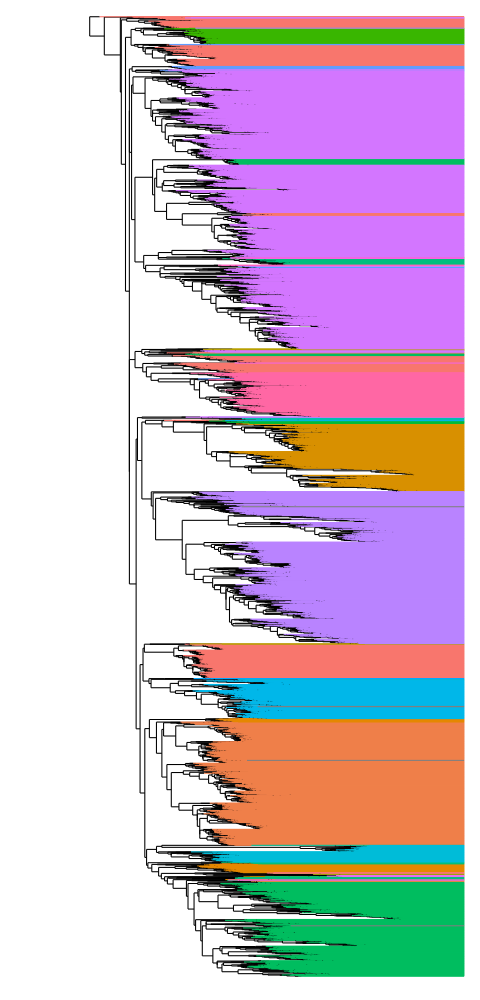

In [26]:
%%R -h 1000

plot_tree = function(physeq, color.rank="Rank2", legend.title='Phylum', 
                     plot.margin=NULL, y.expand=c(0.01,0.01),
                     legend.position='none', legend.size=4){
    # general tree plotting with ggplot
    as.Num = function(x){ x %>% as.character %>% as.numeric }
    
    # plot margin
    if(is.null(plot.margin)){
        plot.margin = unit(c(0,0,0,0), "cm")  # top, right, bottom, left        
    }

    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_inner = treeSegs$edgeDT[is.na(treeSegs$edgeDT$OTU)]
    edge_otu = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)]

    # adding taxonomy to left edges
    physeq.tax = physeq %>% tax_table %>% as.matrix %>% as.data.frame %>%
        mutate(OTU = rownames(.))
    edge_otu.df = edge_otu %>% as.matrix %>% as.data.frame %>%
        mutate(xleft = xleft %>% as.Num,
               xright = xright %>% as.Num,
               y = y %>% as.Num)
    edge_otu.df = inner_join(edge_otu.df, physeq.tax, c('OTU' = 'OTU')) %>%
        mutate(Rank2 = gsub('^__', '', Rank2),
               Rank3 = gsub('^__', '', Rank3),
               Rank4 = gsub('^__', '', Rank4),
               Rank5 = gsub('^__', '', Rank5),
               Rank6 = gsub('^__', '', Rank6),
               Rank7 = gsub('^__', '', Rank7),
               Rank8 = gsub('^__', '', Rank8)) 
    
    # adding node-metadata connector lines
    edge_otu.con = edge_otu.df %>%
                     mutate(max.xright = max(xright, na.rm=T),
                            xleft = xright,
                            xright = max.xright)
    
    # dummy facet
    edge_inner$FACET = 1
    
    # making tree plot
    p.tree = ggplot(data=edge_inner) + 
        geom_segment(aes(x=xleft, xend=xright, y=y, yend=y)) + 
        geom_segment(data=edge_otu.df, 
                     aes(x=xleft, xend=xright, y=y, yend=y)) +
        geom_segment(data=edge_otu.con,
                     aes_string(x="xleft", xend="xright", y="y", 
                                yend="y", color=color.rank)) + 
        geom_segment(data=treeSegs$vertDT, 
                     aes(x=x, xend=x, y=vmin, yend=vmax)) +
        scale_y_continuous(expand=y.expand) +
        scale_color_discrete(legend.title) +
        facet_grid(. ~ FACET) +
        theme_bw() +
        guides(colour = guide_legend(override.aes = list(size=legend.size))) +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            legend.position = legend.position,
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank(),
            plot.margin = plot.margin
            )
    return(p.tree)
    }

#-- test --#
p.tree = plot_tree(physeq.Full, 
          legend.title='Phylum', 
          legend.position='none', 
          plot.margin=unit(c(0,-0.1,0,2),'cm'))
p.tree

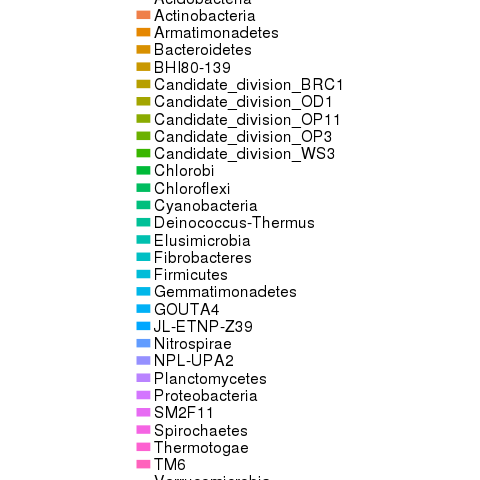

In [28]:
%%R

g_legend = function(a.gplot, text.size = 20, legend.position=c(0.5, 0.5)){ 
    # function for plotting just legend
    a.gplot = a.gplot + theme(legend.position=legend.position, 
                              text = element_text(size=text.size))
    tmp = ggplot_gtable(ggplot_build(a.gplot)) 
    leg = which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
    legend = tmp$grobs[[leg]] 
    return(legend)
    } 
                        
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [29]:
%%R 

as.Num = function(x){ x %>% as.character %>% as.numeric }

order_metadata_to_tree = function(physeq, metadata){
    # function for parsing & giving y (y.tree) value to metadata
        
    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_otu.df = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)] %>%
                as.matrix %>% 
                as.data.frame %>%
                mutate(y.tree = y %>% as.Num) %>%
                select(OTU, y.tree)
    
    # joining leaf edge and metadata
    inner_join(edge_otu.df, metadata, c('OTU' = 'OTU'))     
    }

#-- test --#
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)

df.l2fc.ord = order_metadata_to_tree(physeq.Full, df.l2fc.s) 
df.l2fc.ord %>% head(n=4)

       OTU y.tree   baseMean log2FoldChange    pvalue      padj  Plant
1 OTU.5899   4982 0.35298708    0.002906913 0.9958893        NA 75-062
2 OTU.5899   4982 0.18299079    0.445605737 0.5811108 0.9997733  ABUTH
3 OTU.5899   4982 0.09699412   -0.328169561 0.5941906        NA  AMAPO
4 OTU.5899   4982 1.07710568    0.144585063 0.8837755        NA    B73


### Ordering plants by responder similarity

In [30]:
%%R 

# calc wUnifrac distance
calc.wunif.dist = function(physeq, cores=8){
    registerDoParallel(cores=cores)
    wunif.dist = distance(physeq,
                          method = "unifrac", 
                          weighted = TRUE,
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(wunif.dist)
    }


# ordering substrates by w-unifrac distances between plants
order_plants_by_responders = function(metadata, physeq, padj.cutoff=0.05, ...){
   
    # filtering physeq to just incorporators
    responders = metadata %>%
        filter(padj < padj.cutoff)
    taxa.names = taxa_names(physeq)
    taxa.to.rm = taxa.names[taxa.names %in% responders$OTU]
    physeq.cut = prune_taxa(taxa.to.rm, physeq)
    
    # merging samples by Plant
    physeq.cut.merge = merge_samples(physeq.cut, "Plant")
    
    # removing 12C-con
    physeq.md = physeq.cut.merge %>% sample_data
    physeq.md$Plant = rownames(physeq.md)
    sample_data(physeq.cut.merge) = physeq.md
    physeq.cut.merge = prune_samples(physeq.md$Plant != 'BARE', physeq.cut.merge)
        
    # w-unifrac
    wunif.dist = calc.wunif.dist(physeq.cut.merge, ...)
        
    # hclust of w-unifrac values
    wunif.clust = hclust(wunif.dist, method='average')
    
    # ordering metadata by hclust ordering
    Plants = metadata$Plant %>% as.vector %>% unique
    Plants = Plants[wunif.clust$order]
    metadata$Plant = factor(metadata$Plant, levels=Plants)
    
    return(metadata)
}

#-- test --#
#calc.wunif.dist(physeq.thresh, cores=20)
df.l2fc.ord2 = order_plants_by_responders(df.l2fc.ord, physeq.Full, cores=nprocs)
df.l2fc.ord2 %>% head(n=4)

       OTU y.tree   baseMean log2FoldChange    pvalue      padj  Plant
1 OTU.5899   4982 0.35298708    0.002906913 0.9958893        NA 75-062
2 OTU.5899   4982 0.18299079    0.445605737 0.5811108 0.9997733  ABUTH
3 OTU.5899   4982 0.09699412   -0.328169561 0.5941906        NA  AMAPO
4 OTU.5899   4982 1.07710568    0.144585063 0.8837755        NA    B73


## Alternate function to order plants by Day of Sampling or Type of Plant

In [16]:
%%R
sample_data(physeq.Full)$Type %>% levels

[1] "BARE"      "C4_Grass"  "Dicot-Myc" "Dicot-NM"  "Legume"    "Maize"    


In [31]:
%%R
#Function is taking an input deseq object that has been mapped to tree ($y.tree), then ordering the 
#groups by another variable.  Above this is done with the clustering of incorporators.  Here this is done
# with Day of harvest

# Needed inputs
## 1) Metadata ordered to tree, in this case df.l2fc.ord
## 2) Phyloseq object, in this pase Physeq.Full is trimmed within the function to just responders
    
##Goal, order to DAP


# ordering substrates by w-unifrac distances between plants
order_plants_by_day = function(metadata, physeq, ...){
    
    ## remove bare soil controls
    ## Arange by Day and Plant, gather levels and use to order metadata
    physeq.p = subset_samples(physeq, Plant != "BARE") 
        physeq.p.sd = physeq.p %>%        
            sample_data() %>%
            arrange(DAP, Plant) 
        levels(physeq.p.sd$Plant) = unique(physeq.p.sd$Plant)
        PlantOrder = levels(physeq.p.sd$Plant) 

        metadata$Plant = factor(metadata$Plant, levels=PlantOrder)
    
    return(metadata)
}

order_plants_by_type = function(metadata, physeq, ...){
    
## remove bare soil controls
## Arange by Day and Plant, gather levels and use to order metadata
 physeq.p = subset_samples(physeq.Full, Plant != "BARE") 
     sample_data(physeq.p)$Type = factor(sample_data(physeq.p)$Type, 
                                                 levels = c("Maize", "C4_Grass", 
                                                            "Dicot-Myc","Dicot-NM","Legume"))
        physeq.p.sd = physeq.p %>%        
            sample_data() %>%
            arrange(Type)

        PlantOrder = unique(physeq.p.sd$Plant)
        
        
    metadata$Plant = factor(metadata$Plant, levels=PlantOrder)
    return(metadata)
       
}
#-- test --#
#calc.wunif.dist(physeq.thresh, cores=20)
#df.l2fc.ord2 = order_plants_by_day(df.l2fc.ord, physeq.Full, cores=nprocs)
#df.l2fc.ord2 %>% head(n=4)

order_plants_by_Library = function(metadata, physeq, ...){
    
## remove bare soil controls
## Arange by Day and Plant, gather levels and use to order metadata
 physeq.p = subset_samples(physeq.Full, Plant != "BARE") 
     
        physeq.p.sd = physeq.p %>%        
            sample_data() %>%
            arrange(Library)

        PlantOrder = unique(physeq.p.sd$Plant)
        
        
    metadata$Plant = factor(metadata$Plant, levels=PlantOrder)
    return(metadata)
       
}

df.l2fc.ord2 = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
df.l2fc.ord2 %>% head(n=4)

       OTU y.tree   baseMean log2FoldChange    pvalue      padj  Plant
1 OTU.5899   4982 0.35298708    0.002906913 0.9958893        NA 75-062
2 OTU.5899   4982 0.18299079    0.445605737 0.5811108 0.9997733  ABUTH
3 OTU.5899   4982 0.09699412   -0.328169561 0.5941906        NA  AMAPO
4 OTU.5899   4982 1.07710568    0.144585063 0.8837755        NA    B73


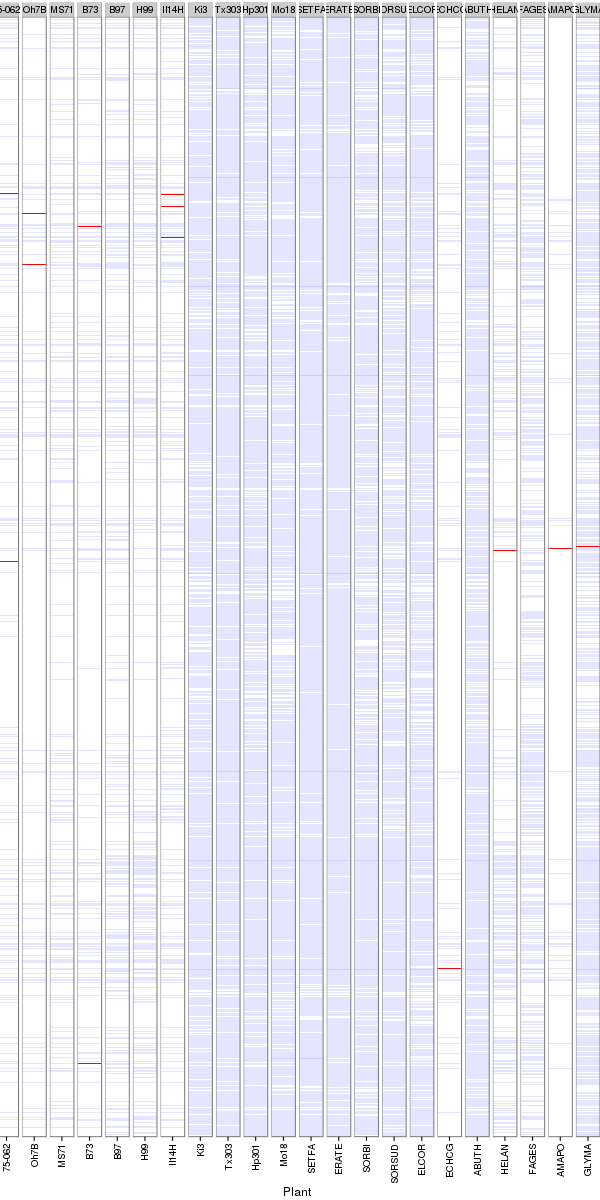

In [37]:
%%R -w 600 -h 1200

# function for making incorporator plot
responders_plot = function(metadata, plot.margin=NULL){
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,-0.7), "cm")  # top, right, bottom, left        
    }
    
    metadata.ord = metadata %>%
        mutate(responder = padj < 0.05,
               responder.num = responder %>% as.numeric)
    
    min.y = metadata.ord$y.tree %>% min(na.rm=T)
    max.y = metadata.ord$y.tree %>% max(na.rm=T)    
    
    p.responder = ggplot(metadata.ord, aes(Plant, y.tree, fill=responder, alpha=responder.num)) +
        geom_tile() +
        scale_fill_manual(values=c('blue', 'red')) +
        scale_y_continuous(expand=c(0,0)) +
        facet_grid(. ~ Plant, scales='free_x') +
        theme_bw() +
        theme(panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
           axis.ticks.y = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin    
            )   
    return(p.responder)
    }

#-- test --#
p.responders = responders_plot(df.l2fc.ord2)
p.responders

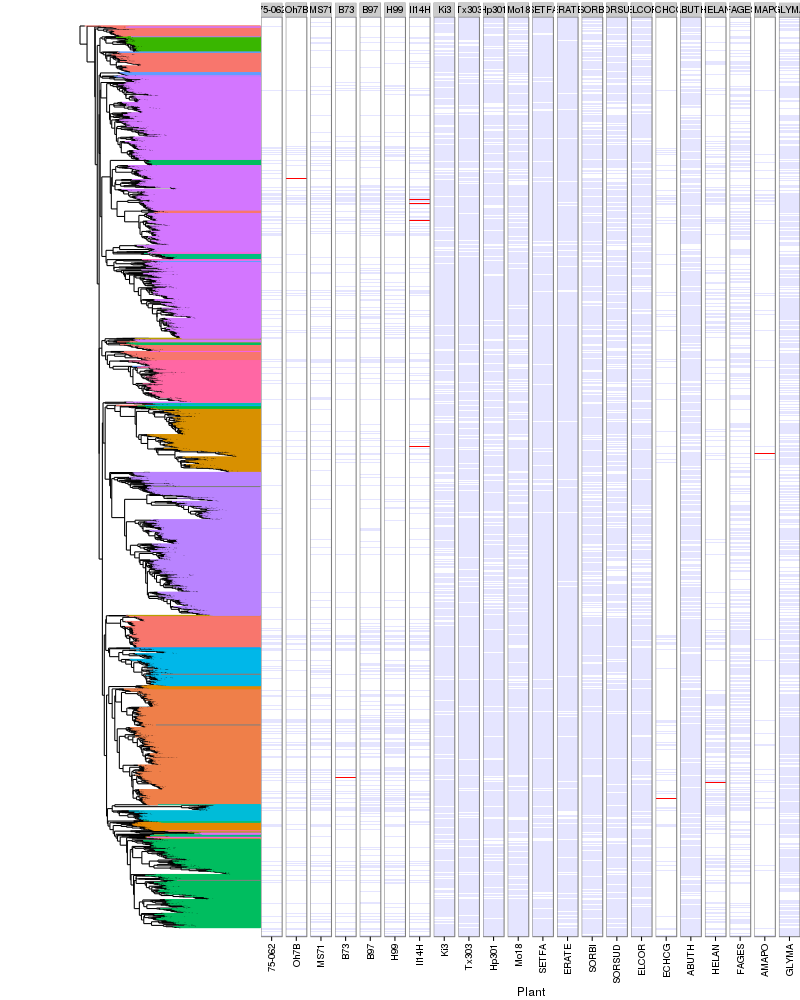

In [36]:
%%R -w 800 -h 1000
    
resize_ggplots = function(ggplot.list,
                          resize.index = length(ggplot.list),
                          widths=rep(1, length(ggplot.list))){
    # other.plots = list of plots
    stopifnot(class(ggplot.list)[1] == 'list')
    
    ## making gtables
    make_gt = function(x) ggplot_gtable(ggplot_build(x))
    gt = lapply(ggplot.list, make_gt)
        
    # resizing
    gt.len = length(gt)    
    for(i in 1:gt.len){
        if(i == resize.index){
            next
        } else {
            gt[[i]]$heights = gt[[resize.index]]$heights
        }
    }
        
    # grid.arrange params
    params.l = list('ncol' = gt.len, 'widths' = widths)

    # return list of gtables + params
    return(c(gt, params.l))
    } 

x = resize_ggplots(list(p.tree, p.responders), 
                   widths=c(1,2))
do.call(grid.arrange, x)

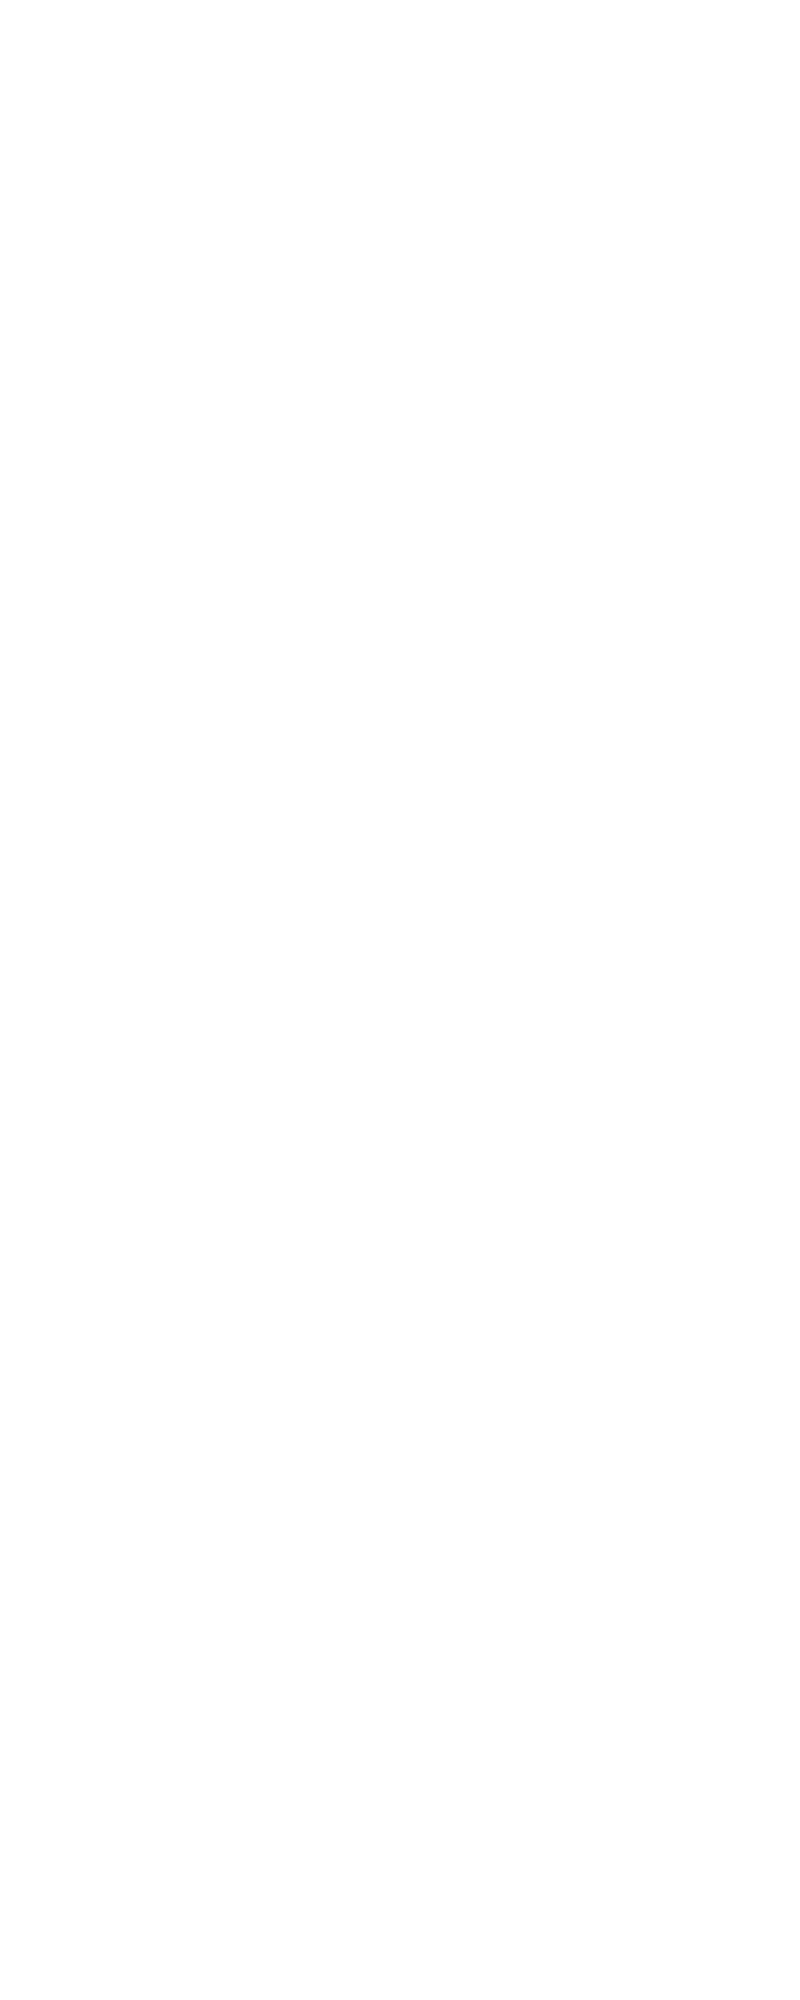

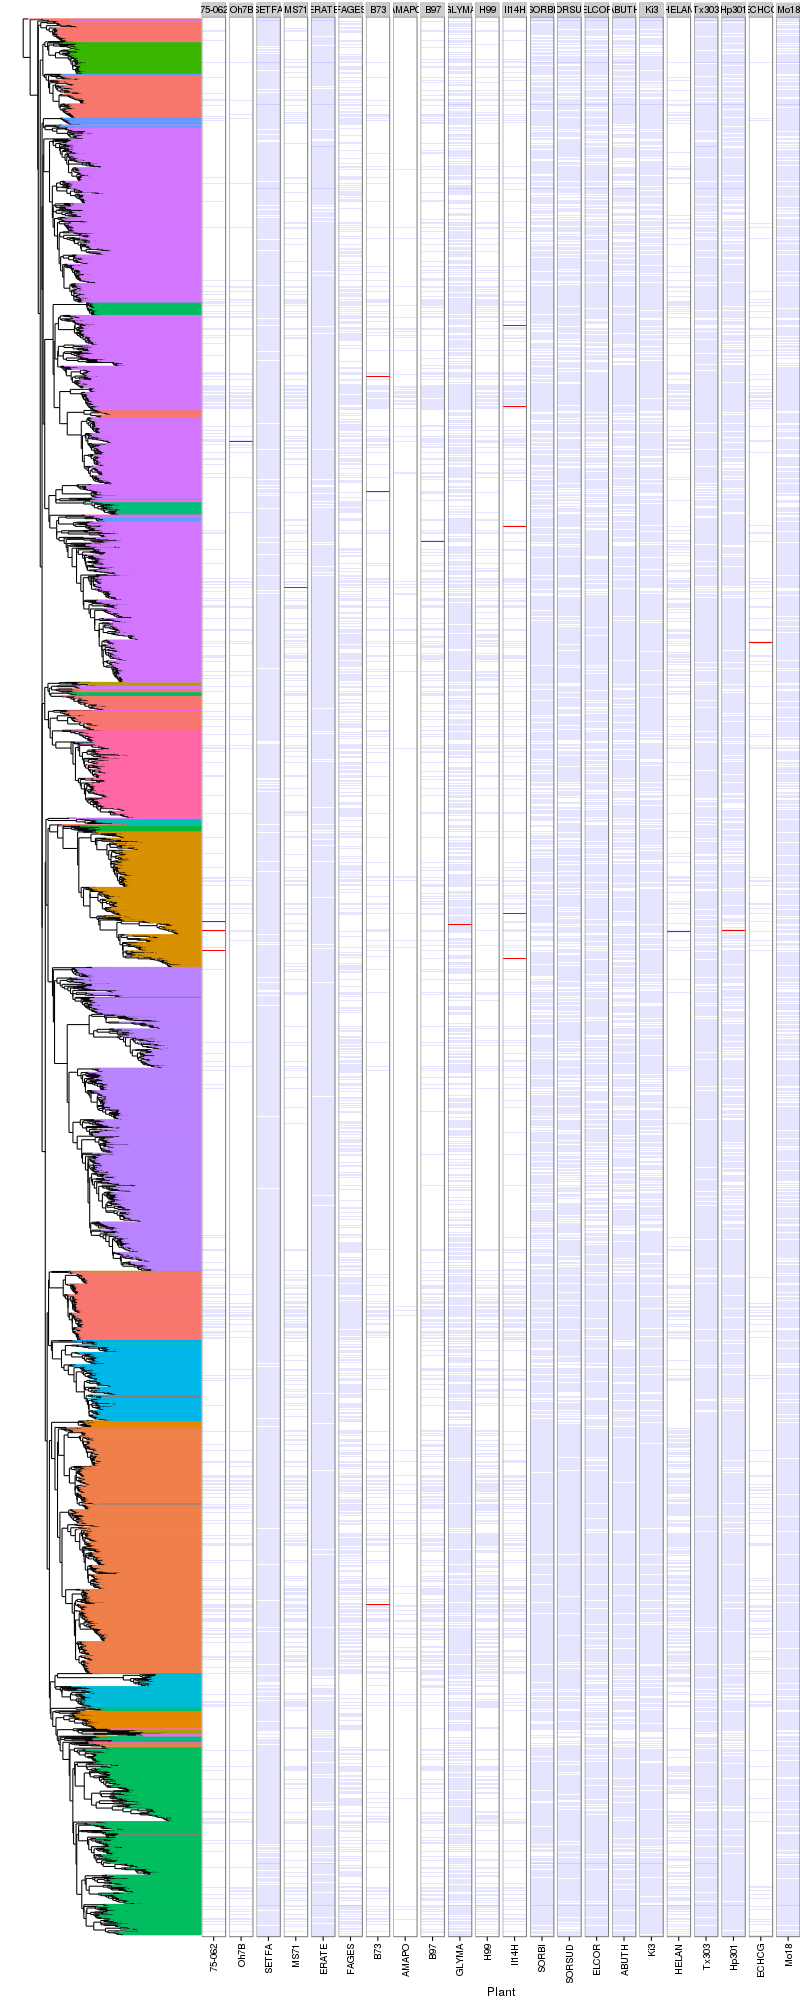

In [50]:
%%R -w 800 -h 2000
# tree plot
p.tree = plot_tree(physeq.Full, 
                   legend.title=' Phylum', 
                   y.expand=c(0.001,0.001),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full, df.l2fc.s) 
## plants by date
df.l2fc.ord = order_plants_by_Library(df.l2fc.ord, physeq.Full, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)


# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,2))
do.call(grid.arrange, gt)

In [65]:
%%R
df.l2fc.ord$OTU %>% unique %>% length

[1] 4982


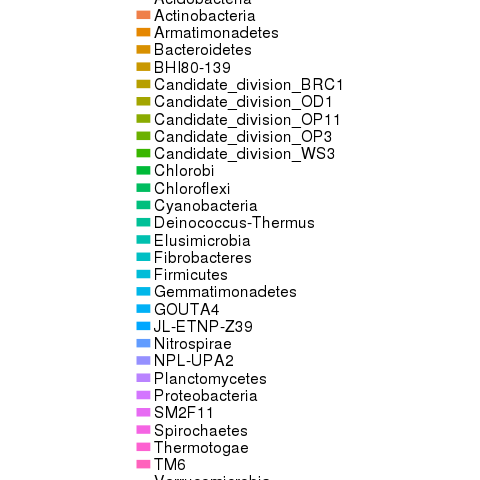

In [51]:
%%R
# tree legend
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [52]:
%%R
# saving figure
outFile = 'allPhyla_NrhizResponders.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')
jpeg(outFile, width= 8, height= 8, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [53]:
%%R 
# saving legend
outFile = 'allPhyla_NrhizResponders_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=2, height=5)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## full tree; just incorporators

In [156]:
%%R
# adding incorporator status to tax_table
p.adj.cutoff = 0.05

physeq.Full.resp = physeq.Full
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8) %>%
    group_by(OTU) %>%
    summarize(Responder = any(p.adj < p.adj.cutoff) %>% as.numeric) %>%
    ungroup() 

tax = physeq.Full.resp %>% tax_table %>% as.data.frame
tax$OTU = rownames(tax)
tax.j = left_join(tax, df.l2fc.s, c('OTU' = 'OTU')) %>% 
    mutate(Responder = ifelse(is.na(Responder), 0, Responder)) %>%
    as.data.frame() 
rownames(tax.j) = tax.j$OTU %>% as.character
tax.j$OTU = NULL

# making new phyloseq object with incorporator info
physeq.Full.resp = phyloseq(physeq.Full.resp %>% otu_table, 
                             tax.j %>% as.matrix %>% tax_table, 
                             physeq.Full.resp %>% sample_data,
                             physeq.Full.resp %>% phy_tree)
physeq.Full.resp = subset_taxa(physeq.Full.resp, Responder==1)
physeq.Full.resp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1506 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 1506 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1506 tips and 1505 internal nodes ]


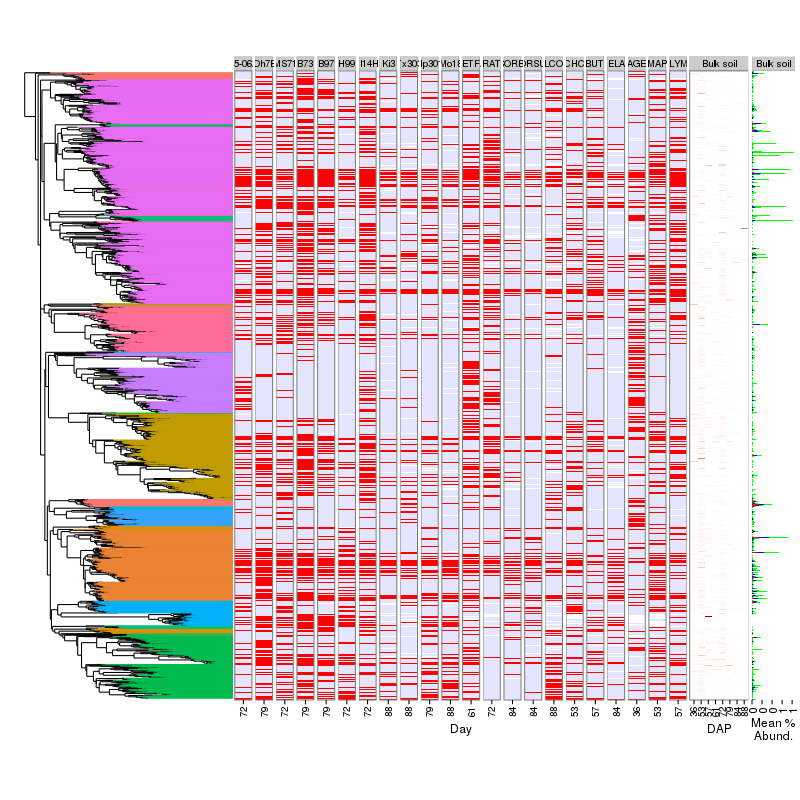

In [157]:
%%R -w 800 -h 800

p.tree = plot_tree(physeq.Full.resp, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full.resp, df.l2fc.s) 
## substrates by similarity of responders
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full.resp, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1.25, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3,0.18,0.15))
do.call(grid.arrange, gt)

### Simple plot: not bulk abundance data

In [35]:
%%R -w 800 -h 800

p.tree = plot_tree(physeq.Full.resp, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.2,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full.resp, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full.resp, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.3))
do.call(grid.arrange, gt)


Error in phy_tree(physeq) : 
  error in evaluating the argument 'physeq' in selecting a method for function 'phy_tree': Error: object 'physeq.Full.resp' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in phy_tree(physeq) : 
  error in evaluating the argument 'physeq' in selecting a method for function 'phy_tree': Error: object 'physeq.Full.resp' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [159]:
%%R
# saving figure
outFile = 'allPhyla-resp_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=800 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [160]:
%%R 
# saving legend
outFile = 'allPhyla-resp_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


### simple plot not bulk abundance data organized by DAP

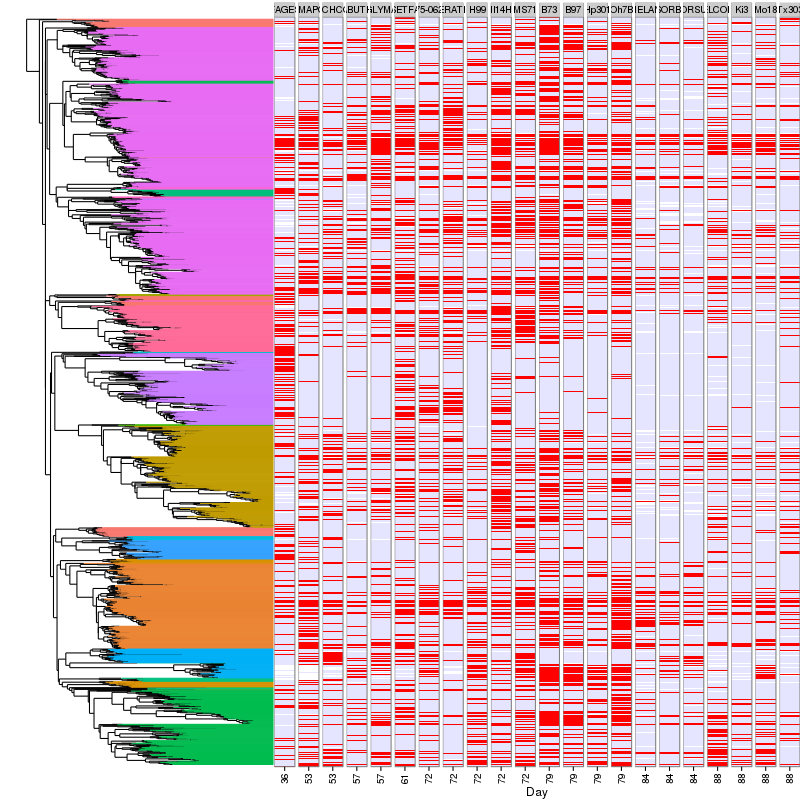

In [161]:
%%R -w 800 -h 800

p.tree = plot_tree(physeq.Full.resp, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.2,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full.resp, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_plants_by_day(df.l2fc.ord, physeq.Full.resp, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.3))
do.call(grid.arrange, gt)

In [162]:
%%R
# saving figure
outFile = 'allPhyla-resp_byDay_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=800 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [163]:
%%R 
# saving legend
outFile = 'allPhyla-resp_byDay_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


# Figures for each phylum

In [164]:
%%R
# ordering plants by full tree order (all incorporators)
full.tree.ord = df.l2fc.ord$Plant %>% levels
full.tree.ord

 [1] "FAGES"  "AMAPO"  "ECHCG"  "ABUTH"  "GLYMA"  "SETFA"  "75-062" "ERATE" 
 [9] "H99"    "Il14H"  "MS71"   "B73"    "B97"    "Hp301"  "Oh7B"   "HELAN" 
[17] "SORBI"  "SORSUD" "ELCOR"  "Ki3"    "Mo18"   "Tx303" 


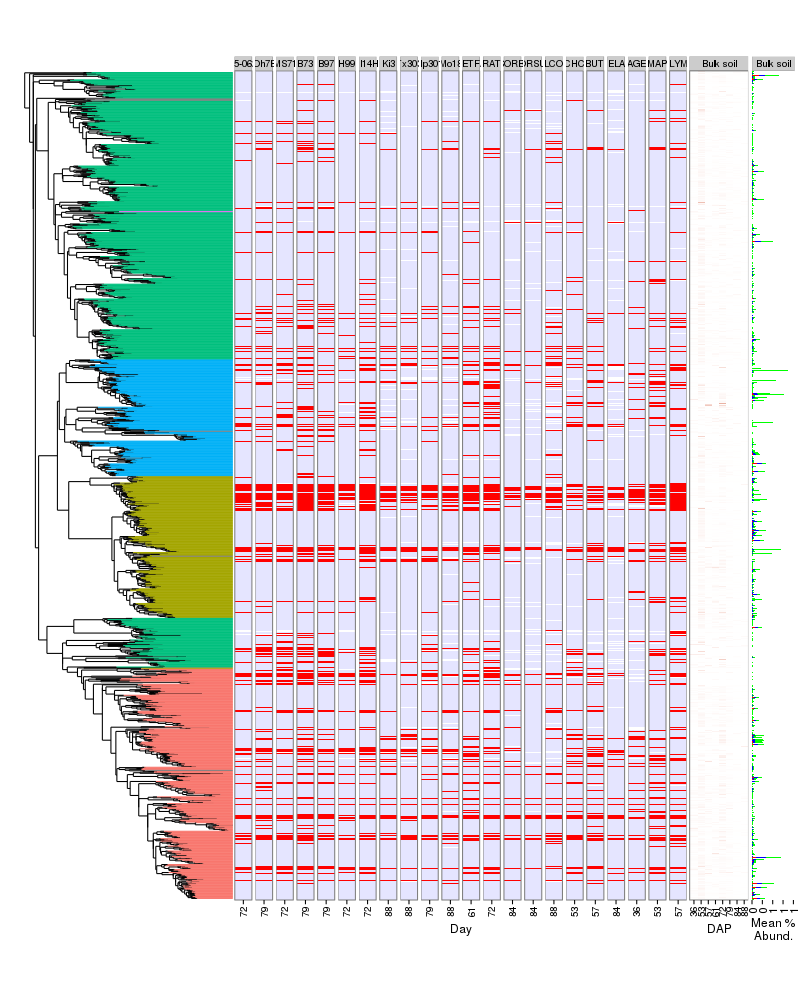

In [187]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Proteobacteria"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3,0.18,0.15))
do.call(grid.arrange, gt)

# Figures for each phylum

In [171]:
%%R
# ordering substrates by full tree order (all incorporators)
full.tree.ord = df.l2fc.ord$Plant %>% levels
full.tree.ord

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR"  "ERATE" 
 [9] "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"    "Mo18"  
[17] "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 


In [175]:
%%R
# total OTU counts for each day (for normalizing)
# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full, df.l2fc.s) 

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.Full, df.l2fc.ord) 

# total OTU counts for bulk soils
total.counts = df.bulk %>% 
    group_by(Day) %>%
    summarize(total_count = sum(count)) %>%
    as.data.frame 

total.counts

  Day total_count
1  36      345731
2  53      538309
3  57      395462
4  61      490806
5  72      460647
6  79      529997
7  84       97075
8  88       86071


In [176]:
%%R
physeq.tax = physeq.Full %>% tax_table %>% as.matrix %>% as.data.frame
physeq.tax$Rank2 %>% table %>% sort(decreasing=T)

.
         Proteobacteria          Planctomycetes          Actinobacteria 
                   1343                     789                     647 
            Chloroflexi           Acidobacteria           Bacteroidetes 
                    529                     472                     355 
        Verrucomicrobia        Gemmatimonadetes              Firmicutes 
                    228                     195                      86 
 Candidate_division_WS3         Armatimonadetes           Cyanobacteria 
                     84                      66                      54 
            Nitrospirae           Elusimicrobia                Chlorobi 
                     39                      15                      13 
Candidate_division_BRC1  Candidate_division_OD1           Fibrobacteres 
                     11                      10                      10 
                 SM2F11            Spirochaetes  Candidate_division_OP3 
                      6                       6  

## Proteobacteria

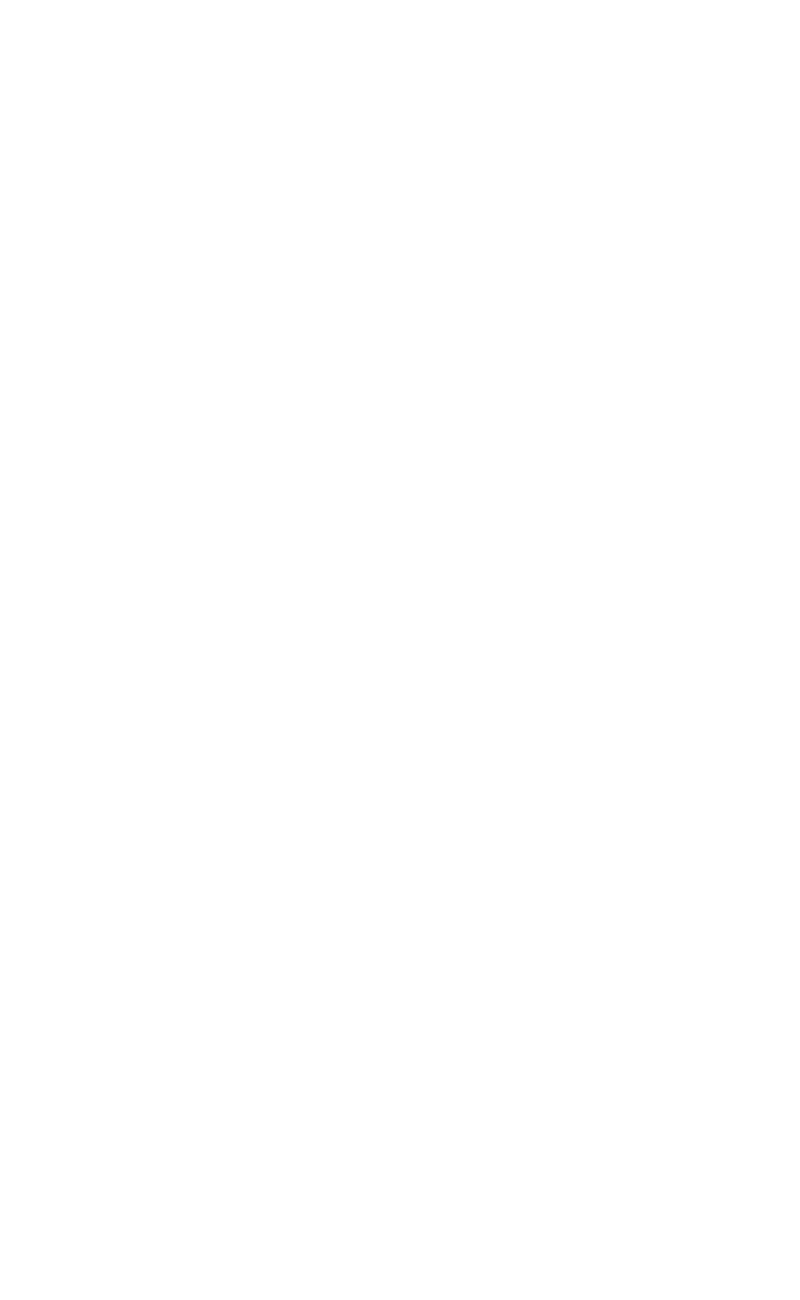

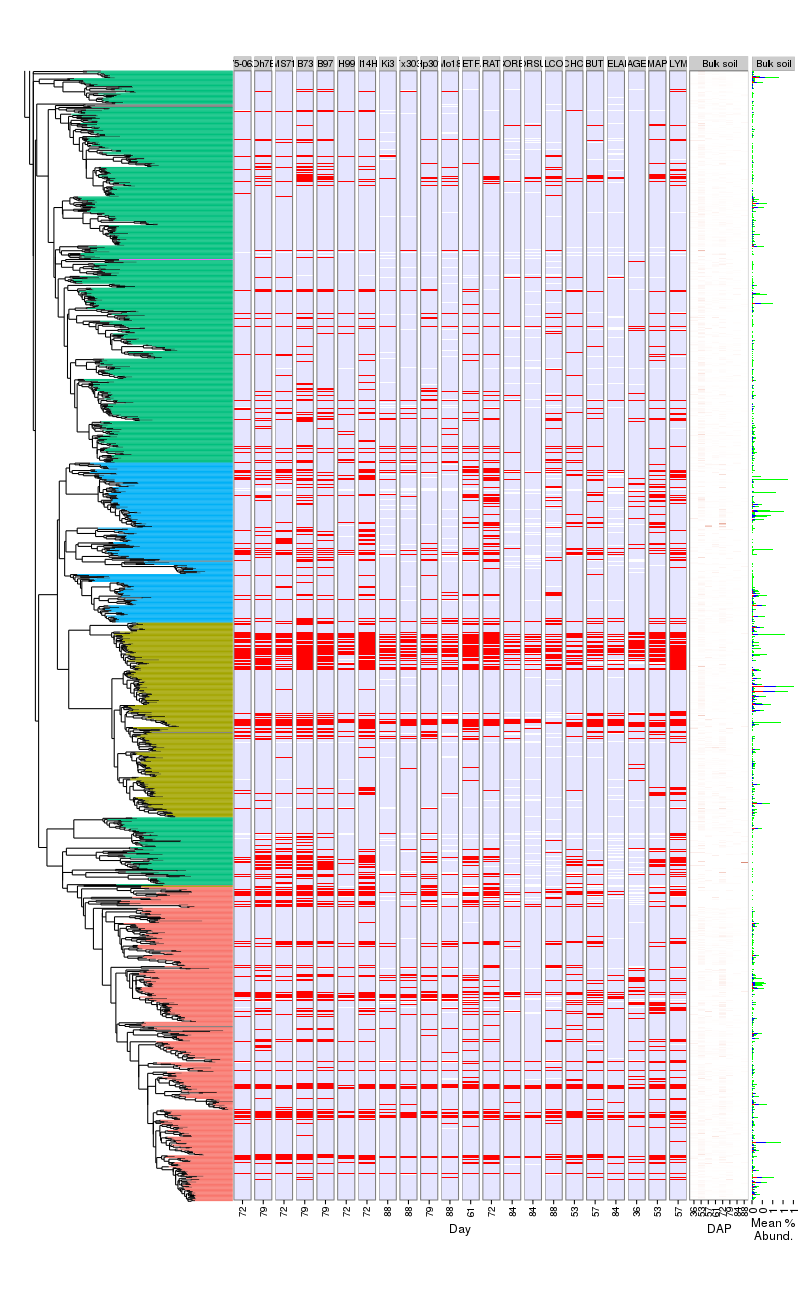

In [202]:
%%R -w 800 -h 1300

# phylum selection
phylum = "Proteobacteria"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3,0.18,0.15))
do.call(grid.arrange, gt)

In [203]:
%%R -i figDir

#outFile = 'Proteo_sparsityCut.pdf'
#outFile = paste(c(figDir, outFile))#, collapse='/')
outFile = 'Proteo_sparsityCut.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
#outFile = file.path(figDir, 'Proteo_sparsityCut.pdf')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


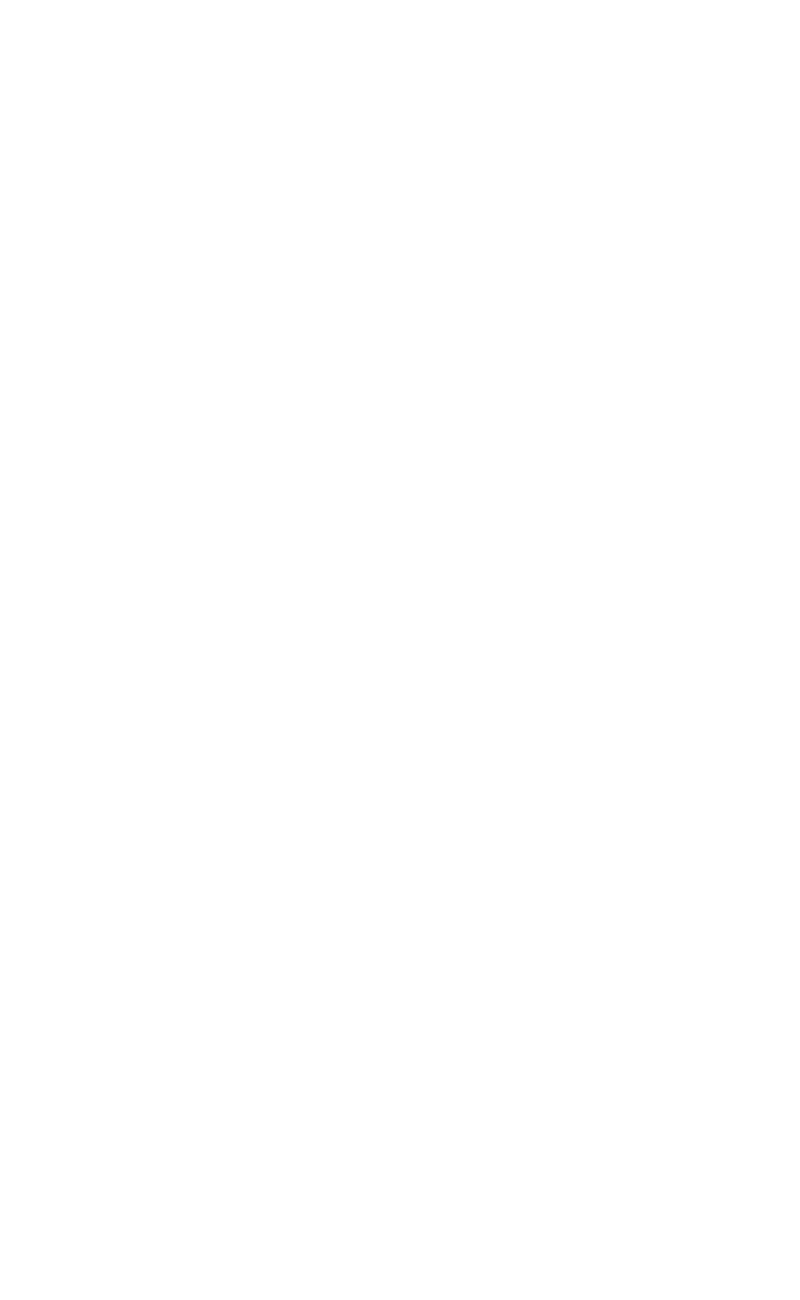

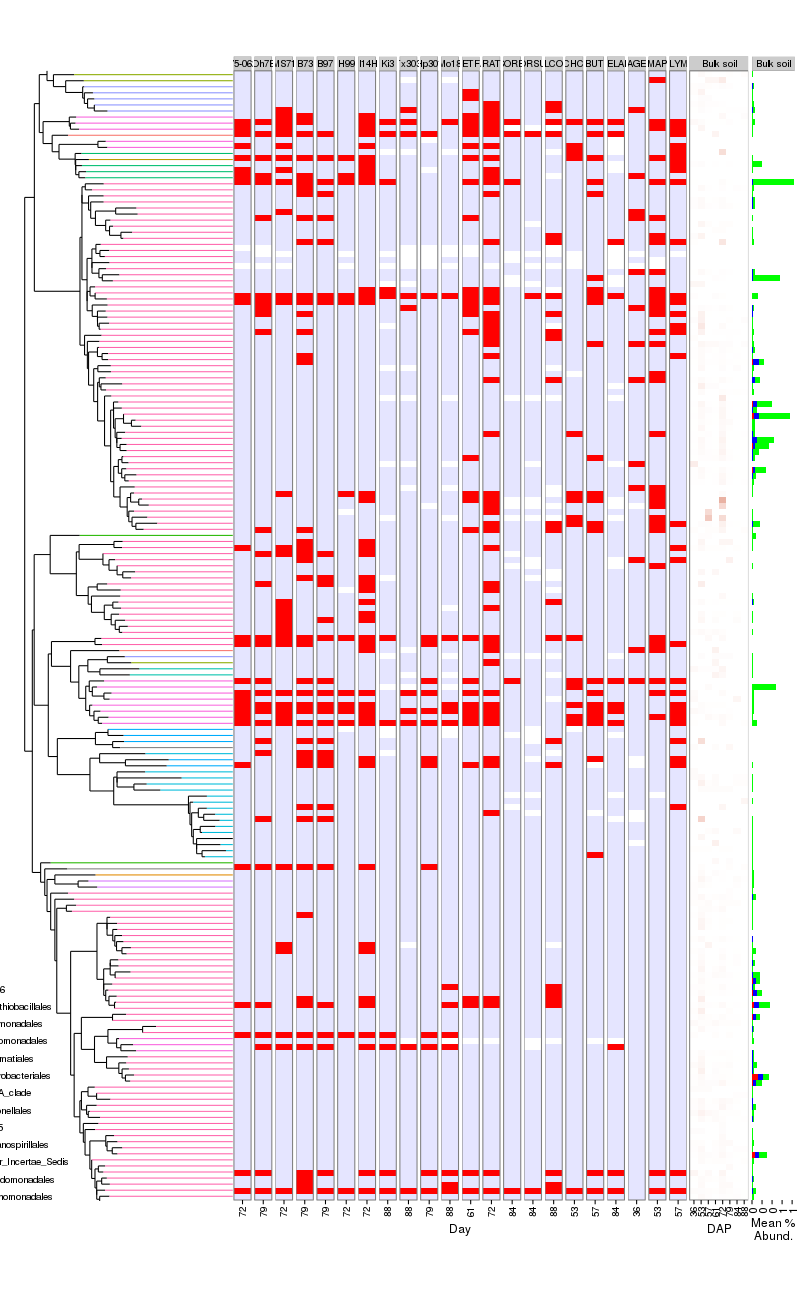

In [206]:
%%R -w 800 -h 1300

# phylum selection
phylum = "Gammaproteobacteria"
physeq_1phy = subset_taxa(physeq.Full, Rank3==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   legend.position=c(0,0.1),
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3,0.18,0.15))
do.call(grid.arrange, gt)

In [207]:
%%R -i figDir

#outFile = 'Proteo_sparsityCut.pdf'
#outFile = paste(c(figDir, outFile))#, collapse='/')
outFile = 'Gamma-Proteo_sparsityCut.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
#outFile = file.path(figDir, 'Proteo_sparsityCut.pdf')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


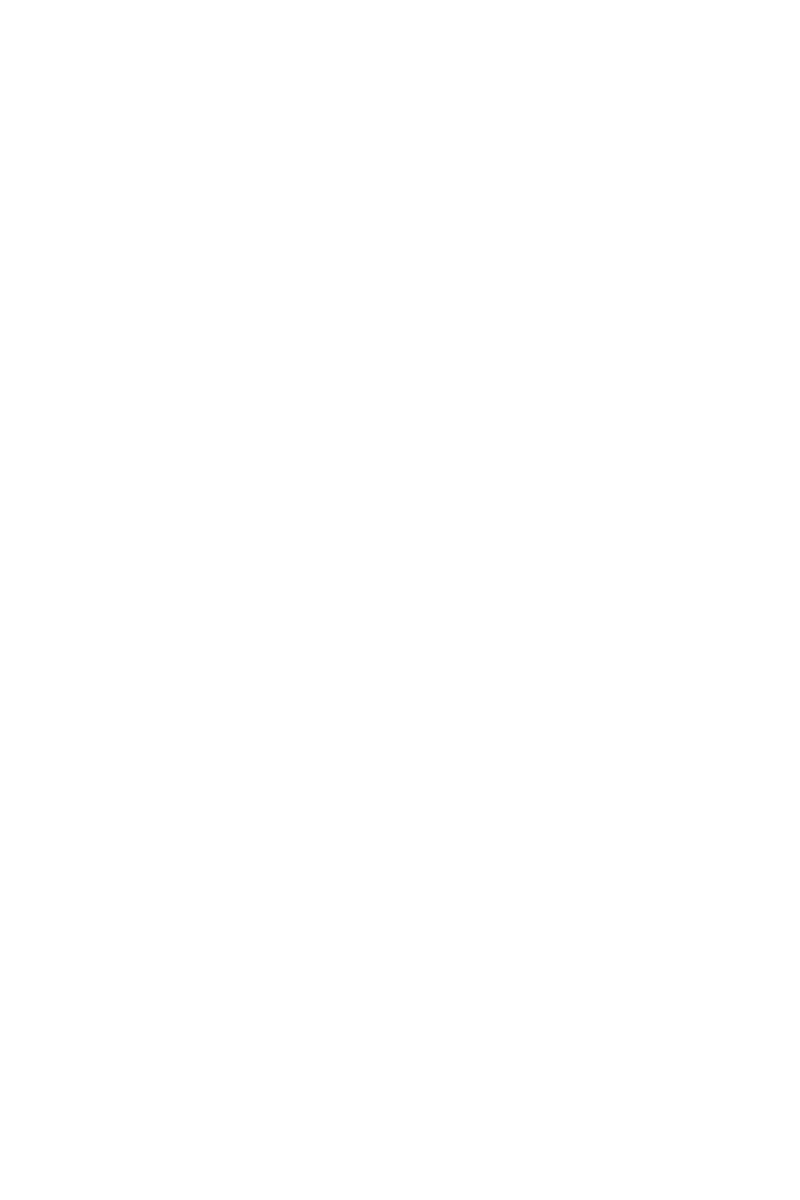

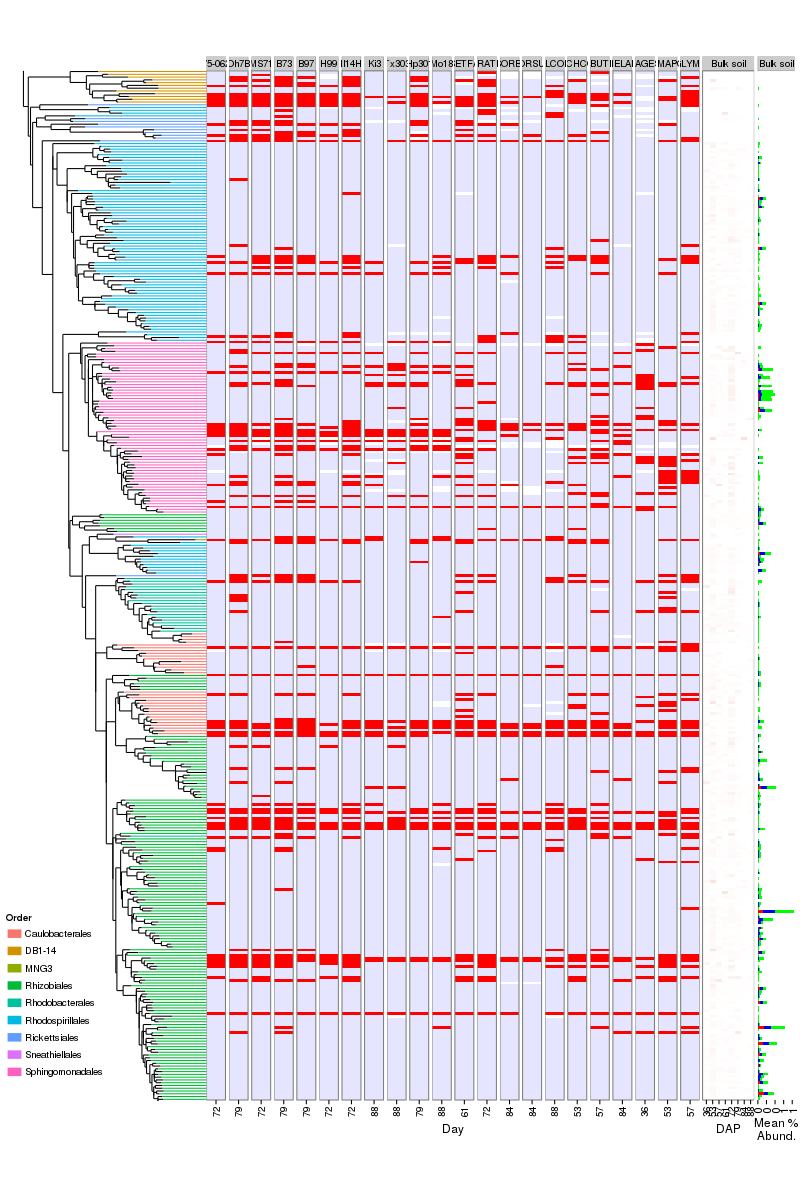

In [218]:
%%R -w 800 -h 1200

# phylum selection
phylum = "Alphaproteobacteria"
physeq_1phy = subset_taxa(physeq.Full, Rank3==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   legend.position=c(0.2,0.1),
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.7,1.6,0.18,0.15))
do.call(grid.arrange, gt)

In [219]:
%%R -i figDir

outFile = 'Alpha_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')

pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


## Actinobacteria

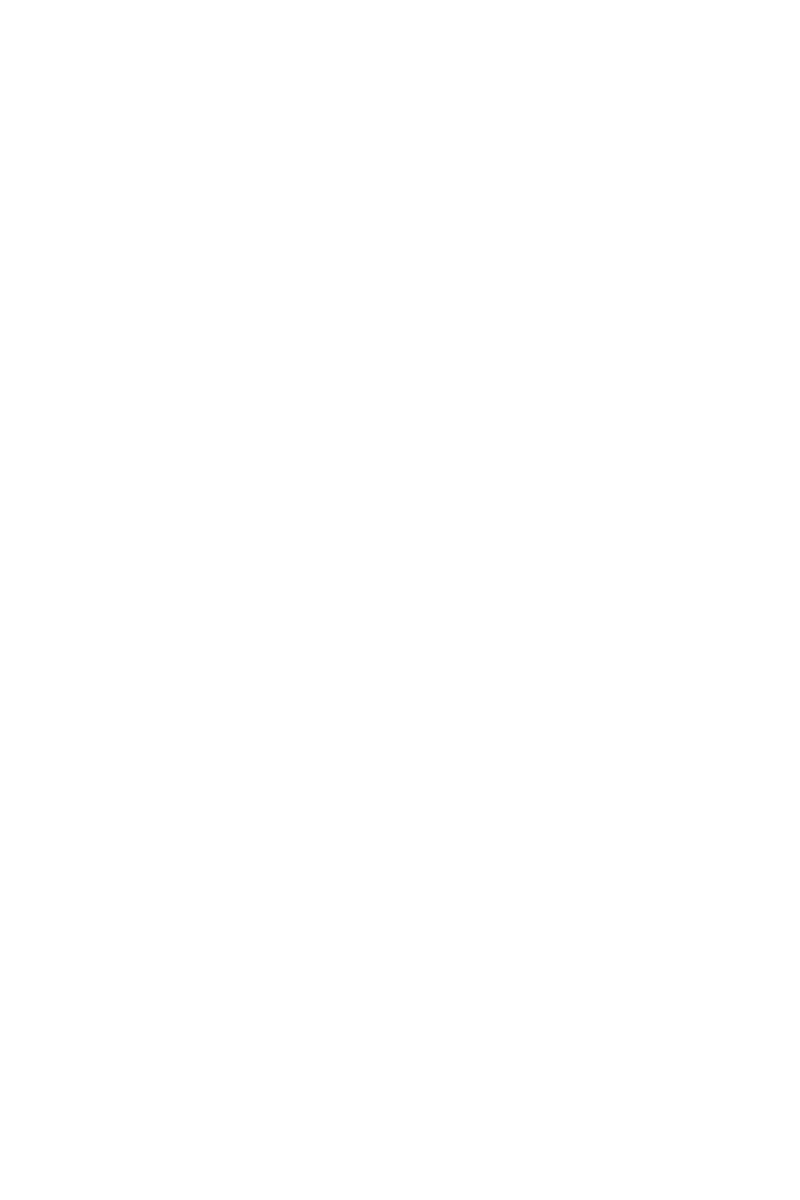

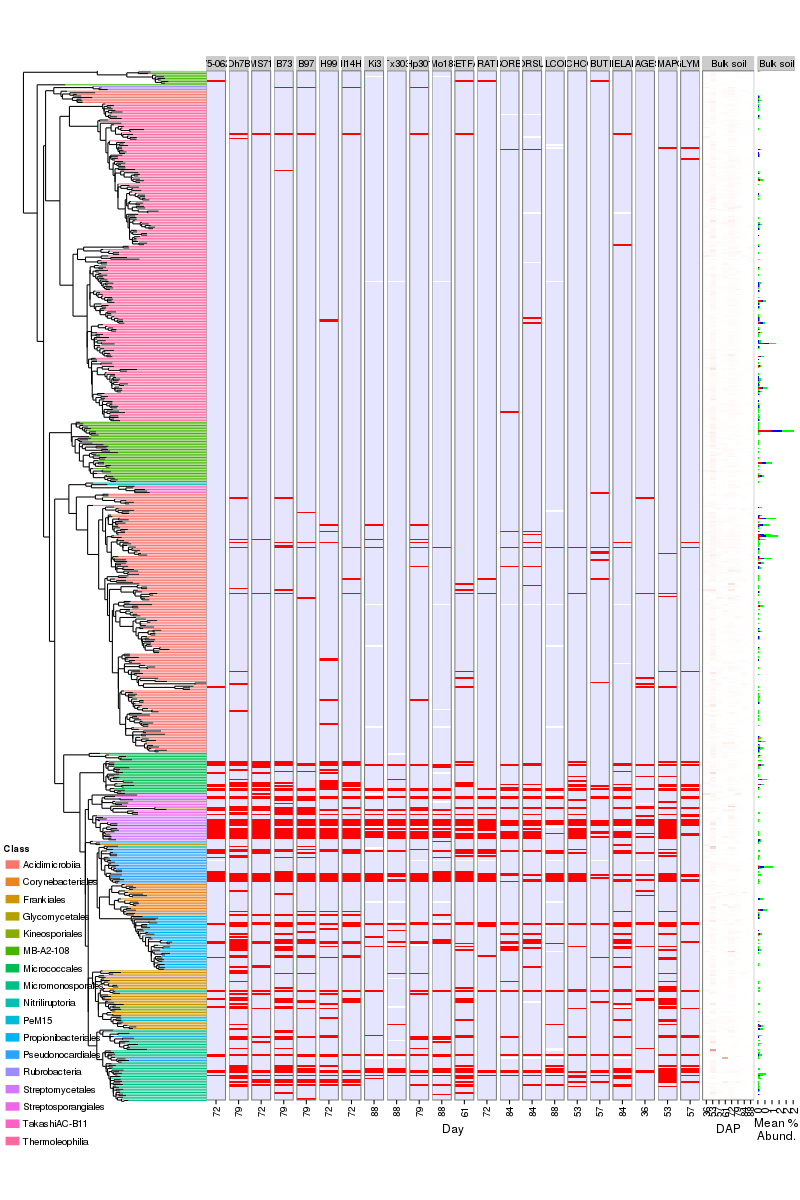

In [220]:
%%R -w 800 -h 1200

# phylum selection
phylum = "Actinobacteria"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.2,0.1),
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.7,1.6,0.18,0.15))
do.call(grid.arrange, gt)

In [222]:
%%R -i figDir

outFile = 'Actino_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


## Planctomycetes

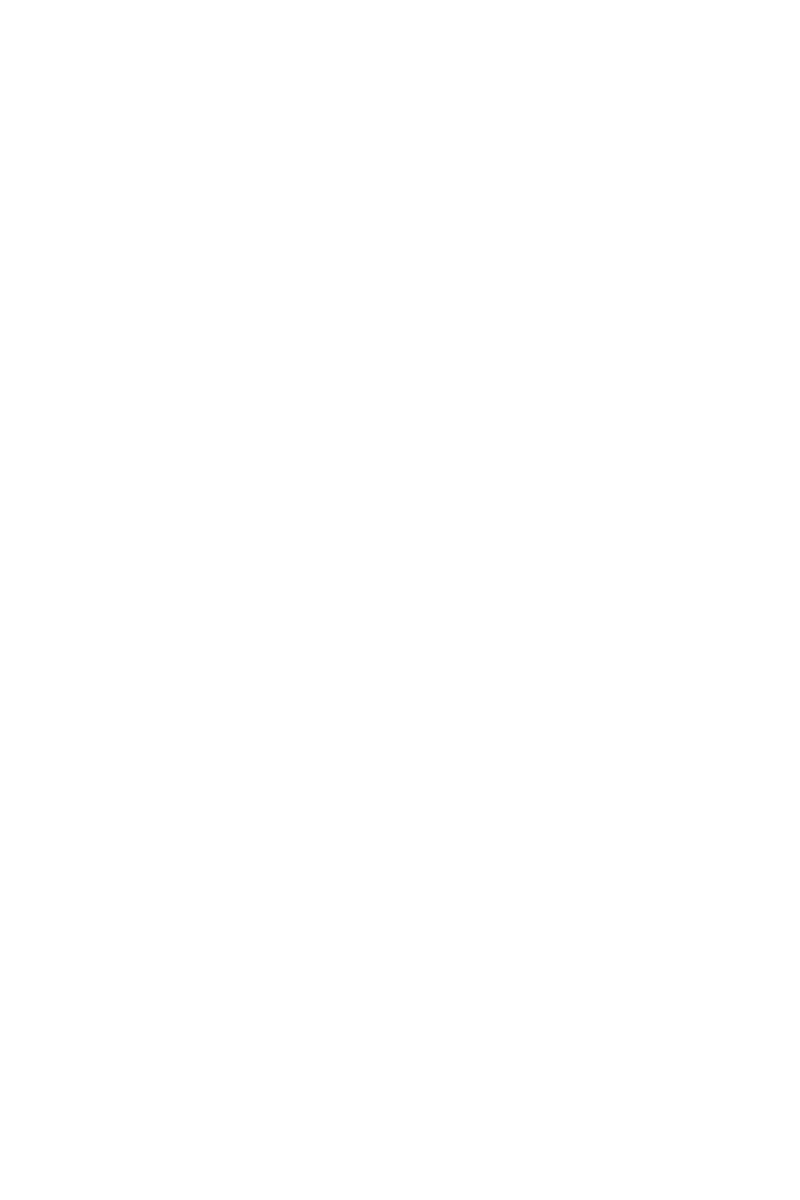

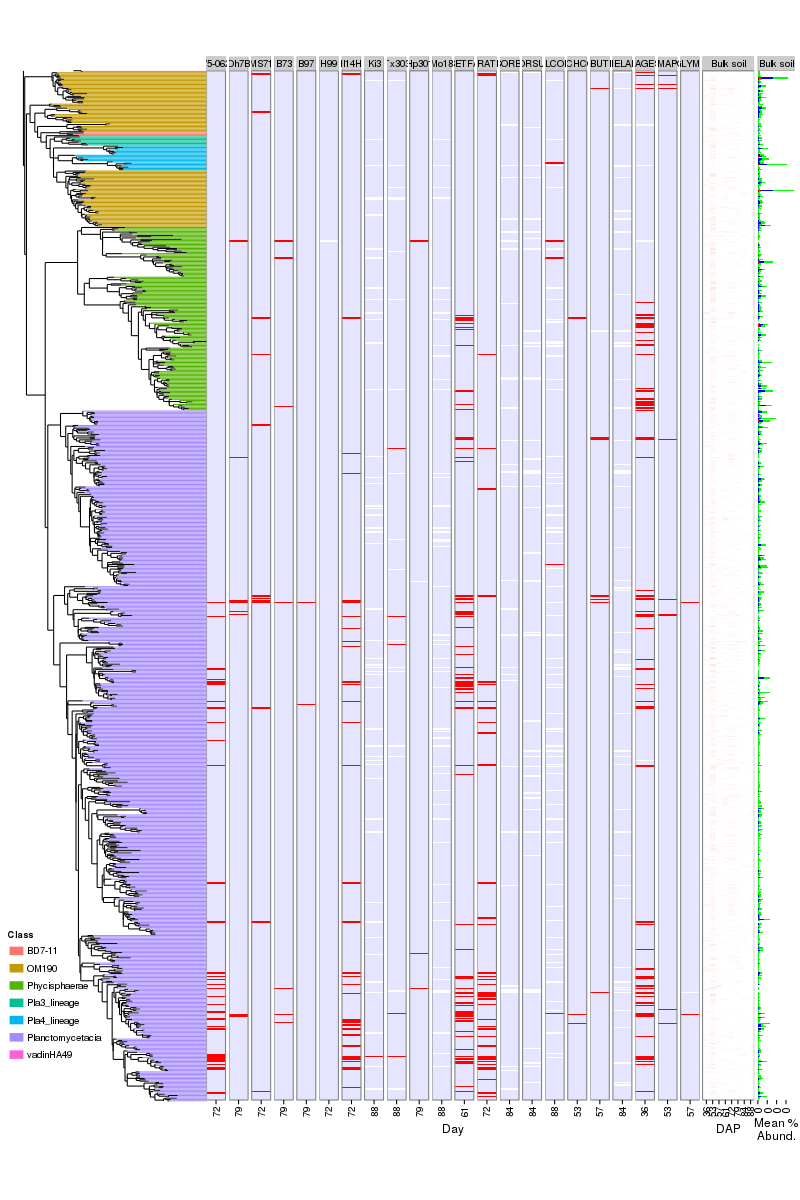

In [223]:
%%R -w 800 -h 1200

# phylum selection
phylum = "Planctomycetes"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.2,0.1),
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.7,1.6,0.18,0.15))
do.call(grid.arrange, gt)

In [224]:
%%R -i figDir

outFile = 'Plancto_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


## Acidobacteria

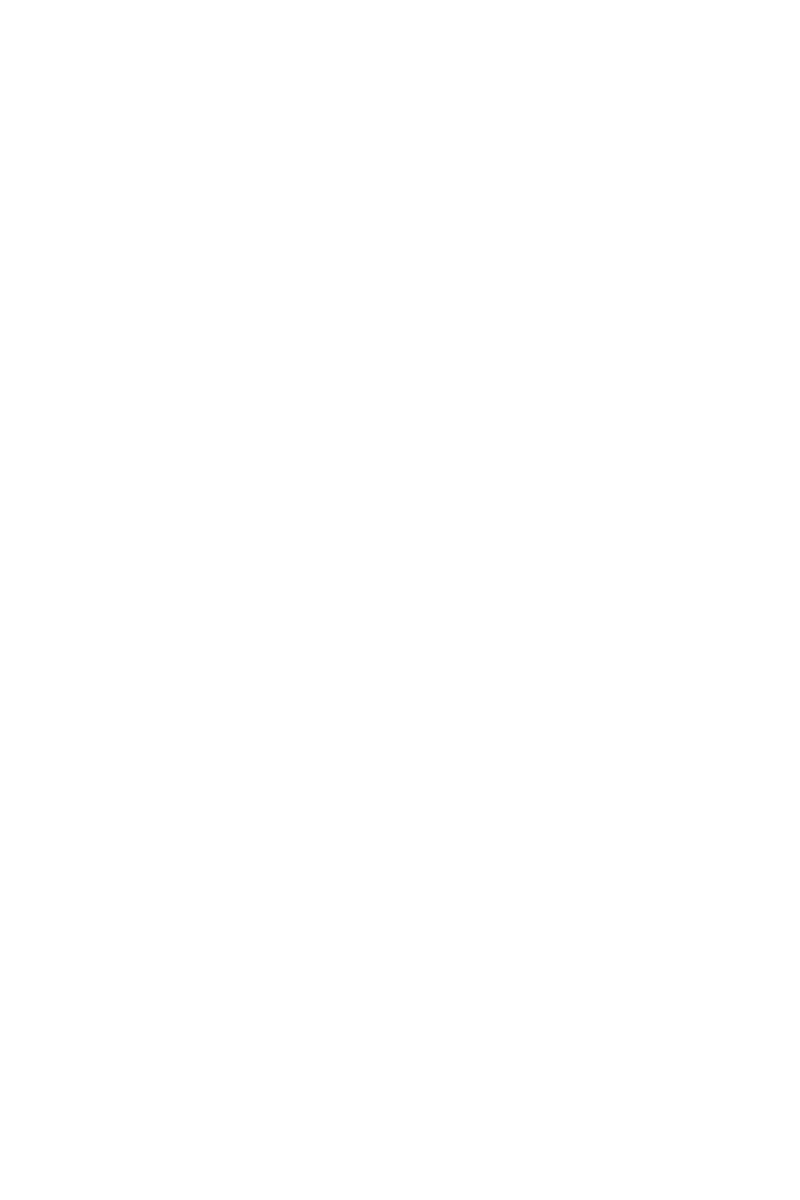

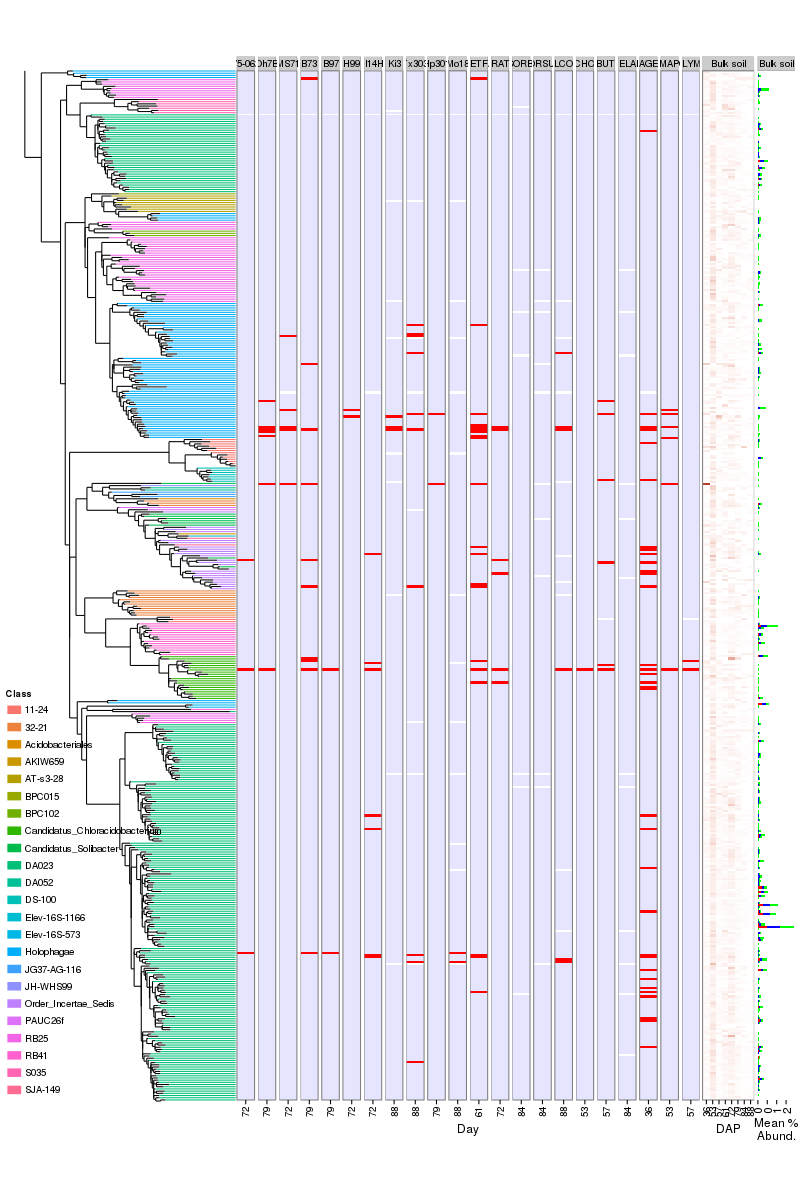

In [226]:
%%R -w 800 -h 1200

# phylum selection
phylum = "Acidobacteria"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.3,0.2),
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.8,1.5,0.18,0.15))
do.call(grid.arrange, gt)

In [227]:
%%R -i figDir

outFile = 'Acido_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


## Chloroflexi

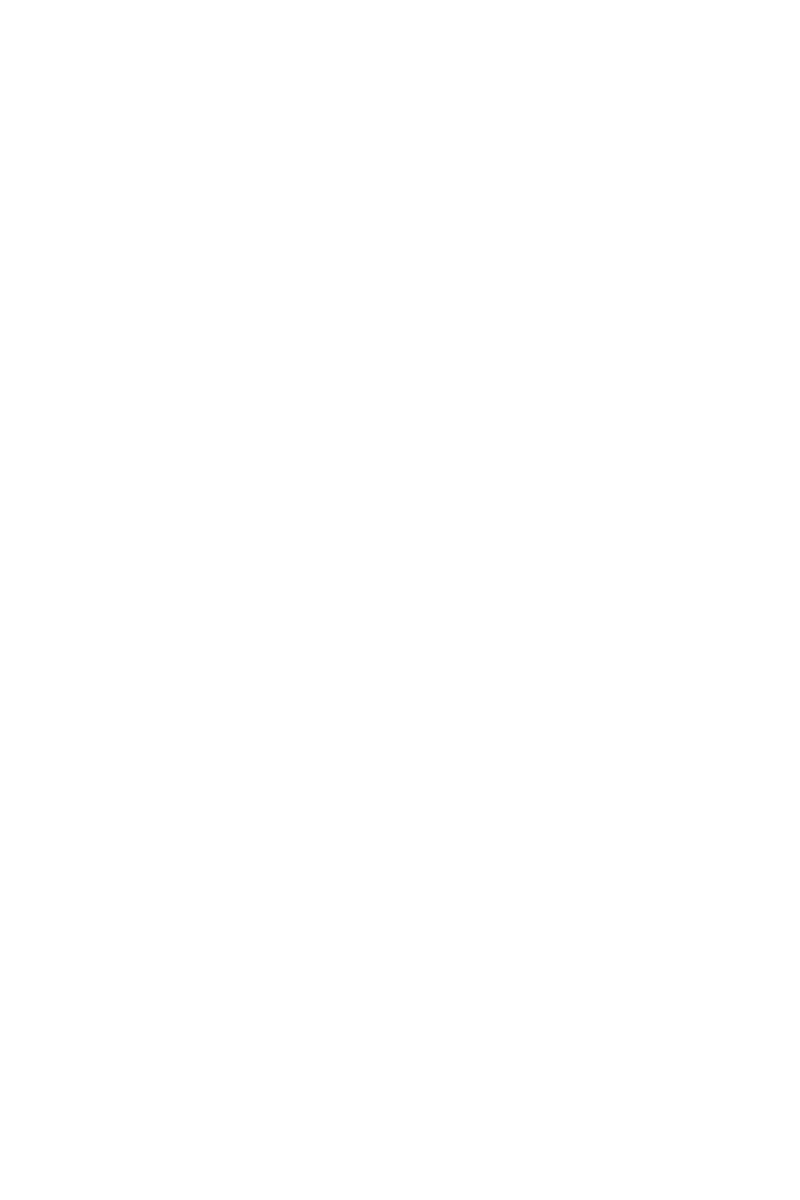

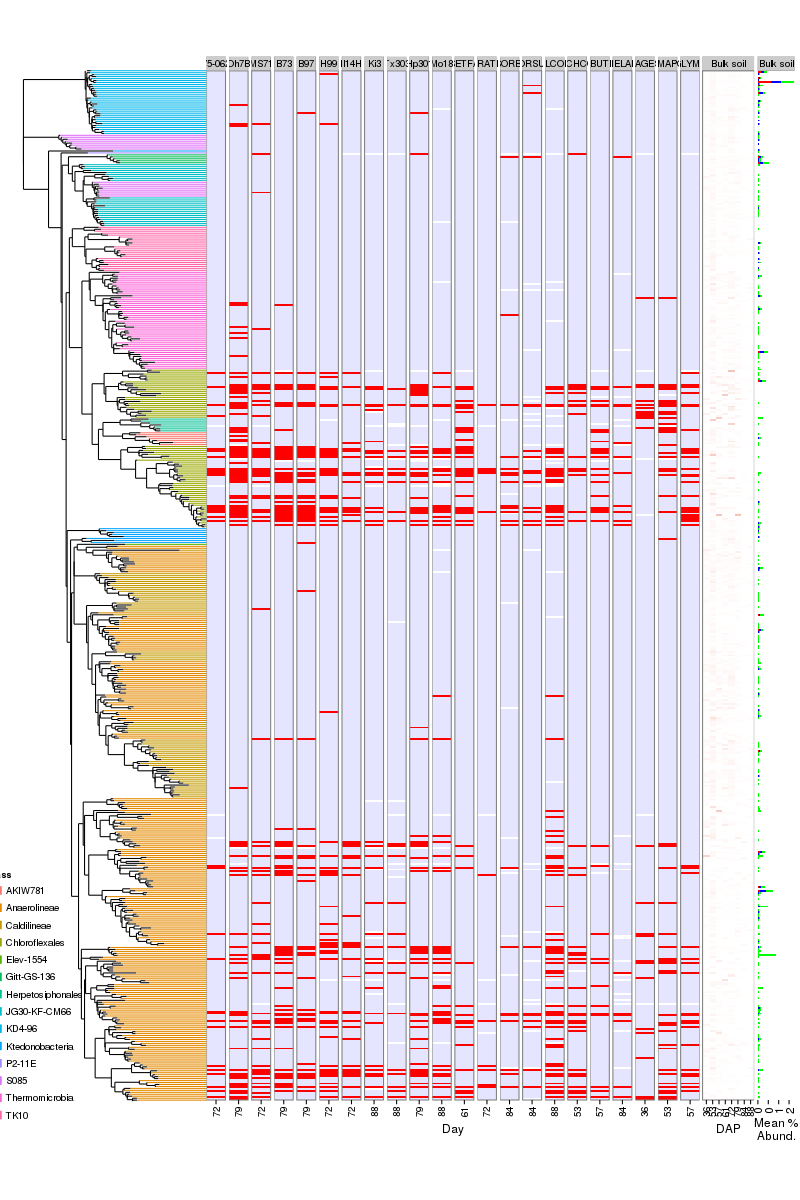

In [229]:
%%R -w 800 -h 1200

# phylum selection
phylum = "Chloroflexi"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.1,0.1),
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.7,1.6,0.18,0.15))
do.call(grid.arrange, gt)

In [230]:
%%R -i figDir

outFile = 'Chloro_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


## Bacteroidetes

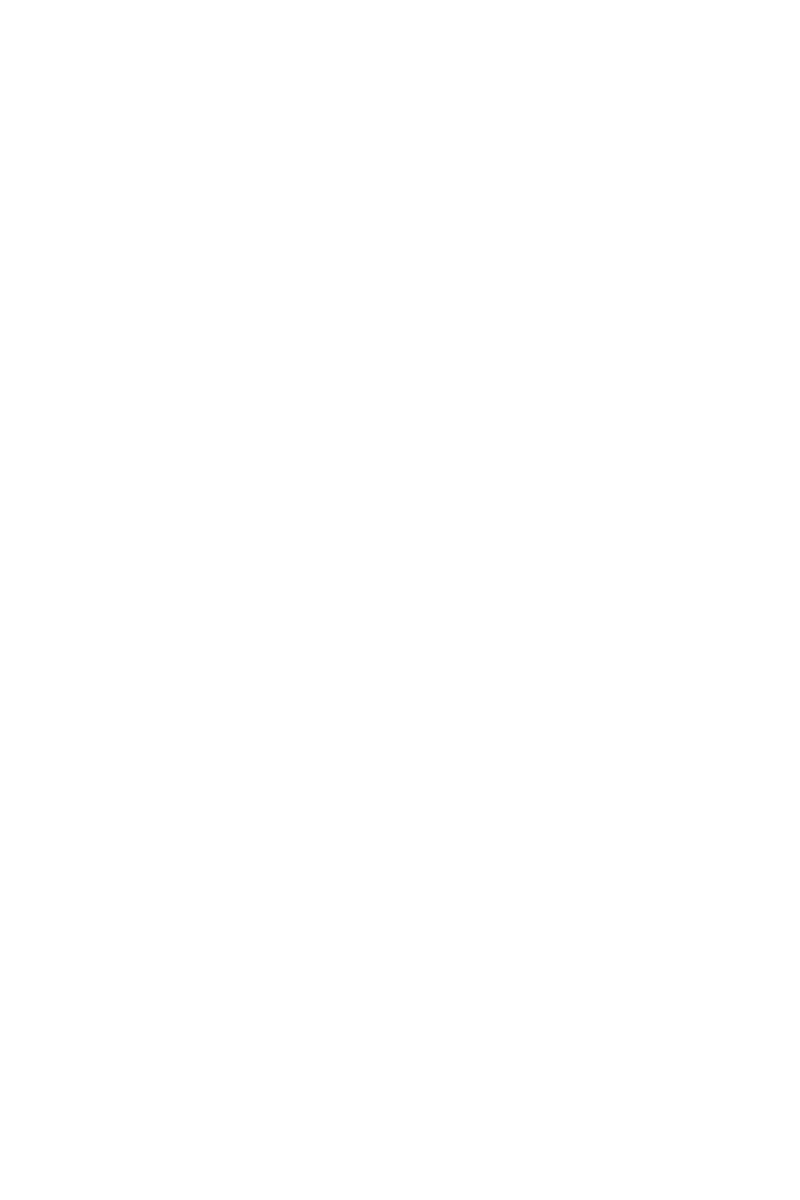

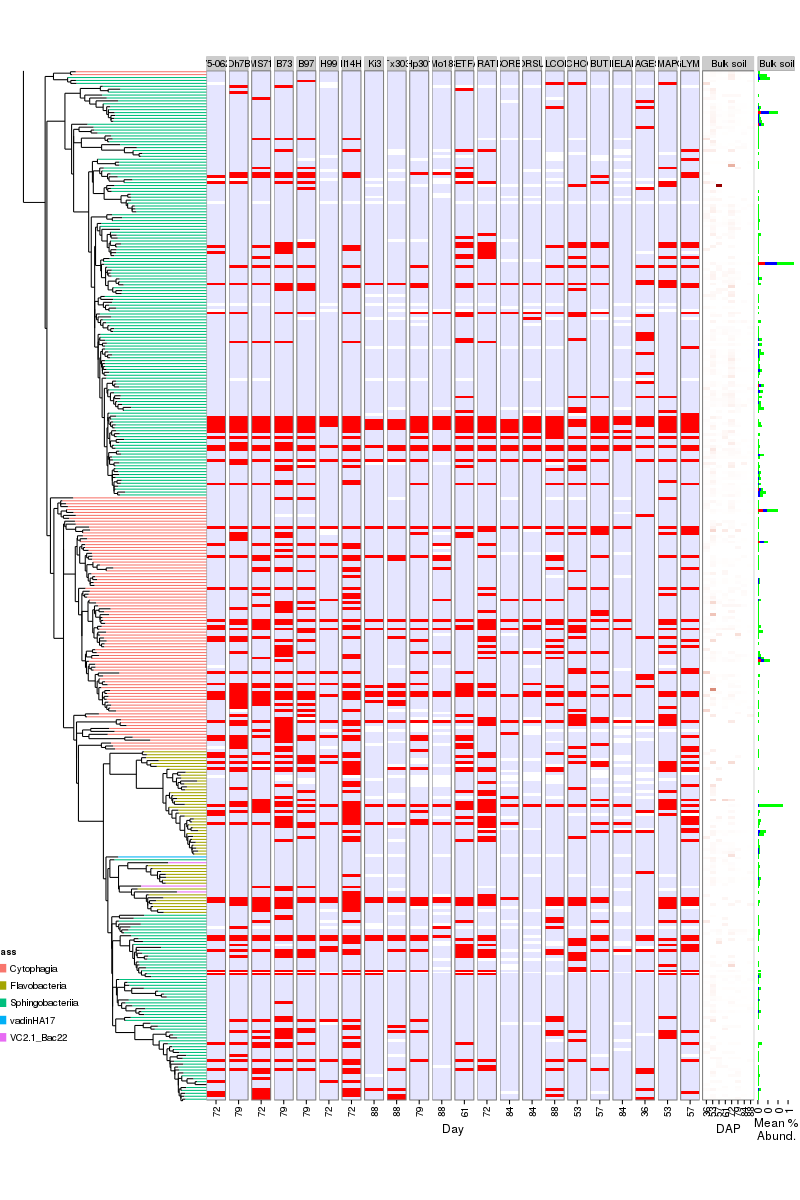

In [233]:
%%R -w 800 -h 1200

# phylum selection
phylum = "Bacteroidetes"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.1,0.1),
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.7,1.6,0.18,0.15))
do.call(grid.arrange, gt)

In [234]:
%%R -i figDir

outFile = 'Bacteroidetes_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


## Verrucomicrobia

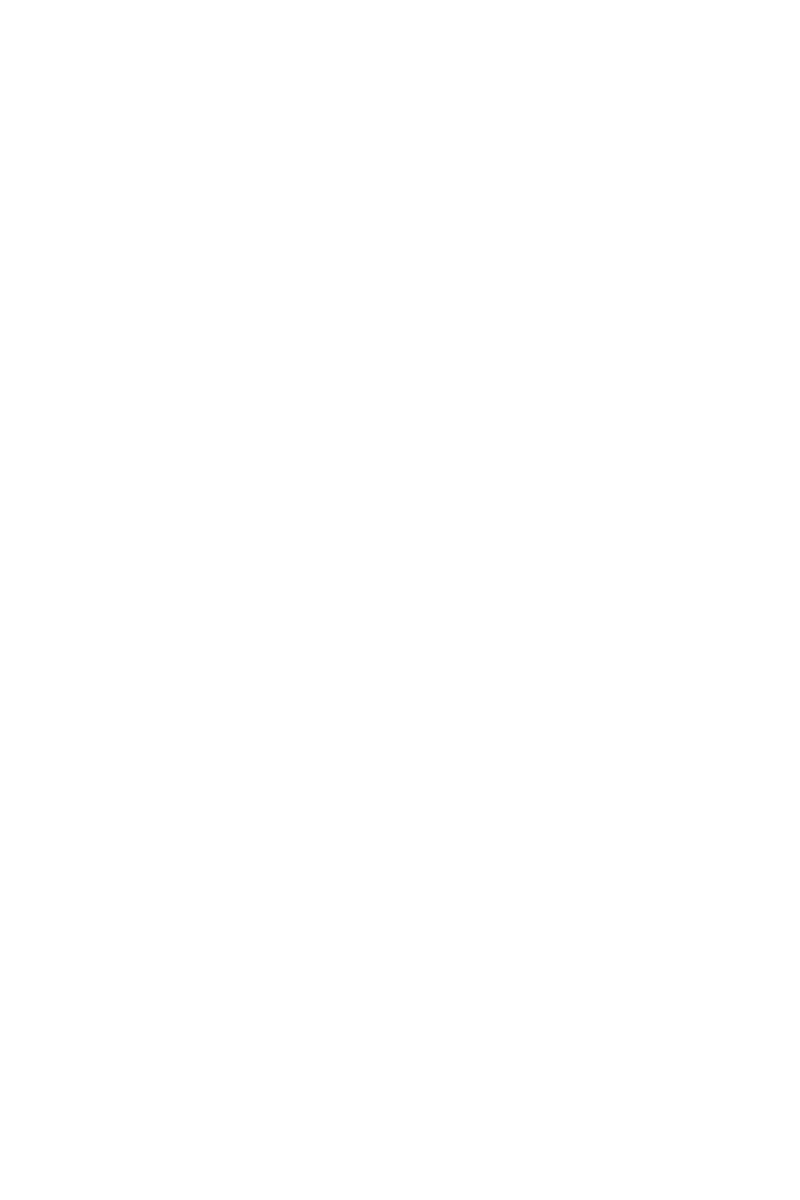

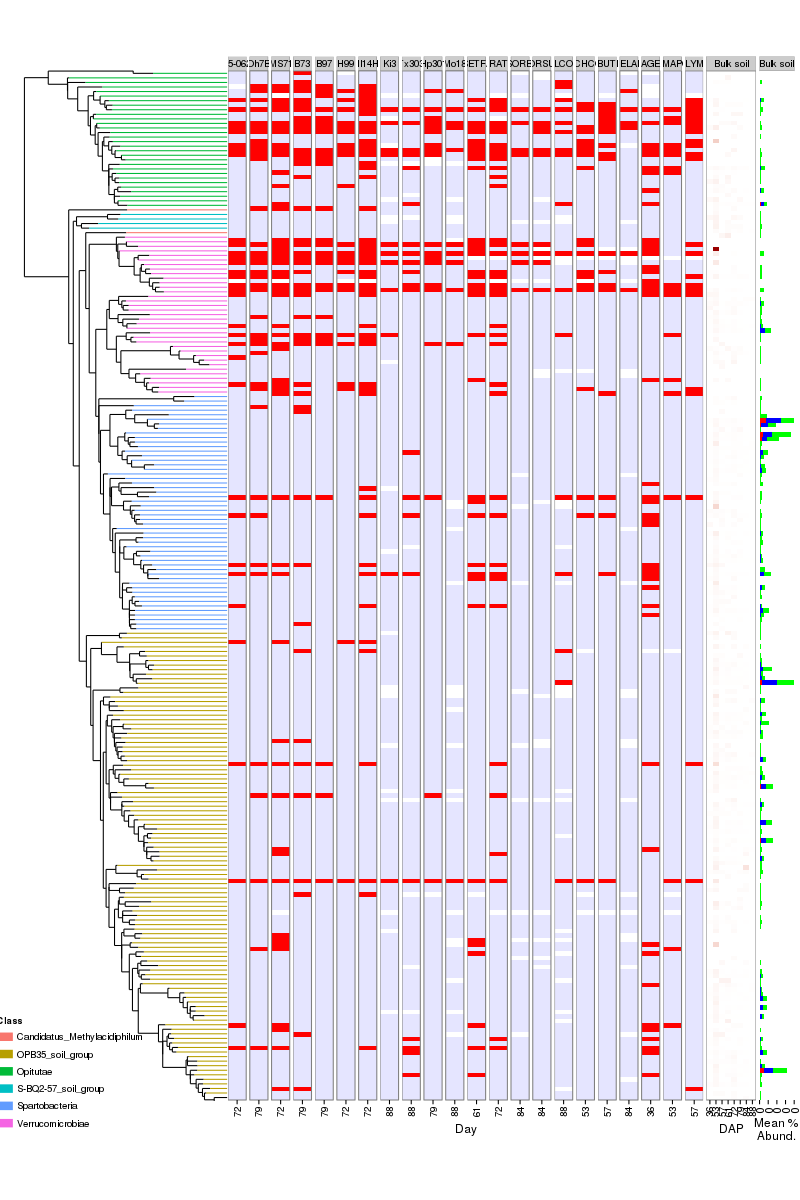

In [238]:
%%R -w 800 -h 1200

# phylum selection
phylum = "Verrucomicrobia"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.25,0.025),
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.8,1.6,0.18,0.15))
do.call(grid.arrange, gt)

In [239]:
%%R -i figDir

outFile = 'Verruco_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


## Firmicutes 

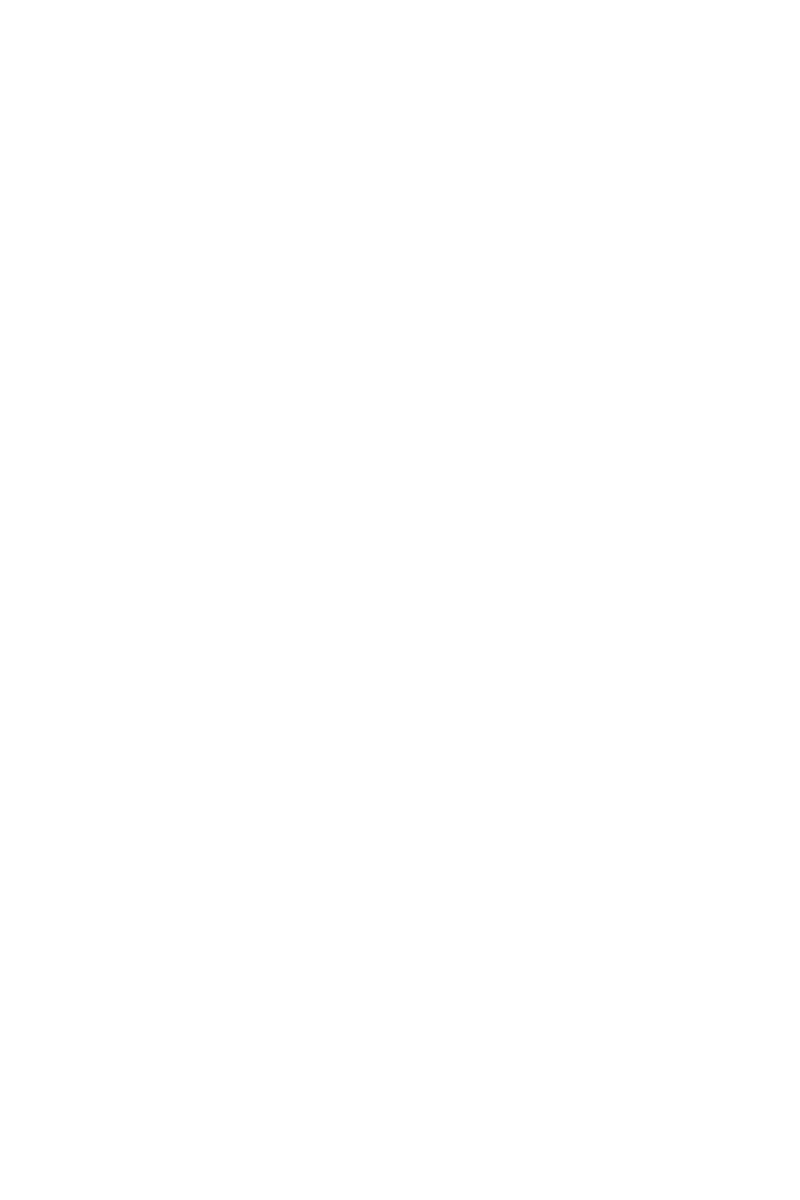

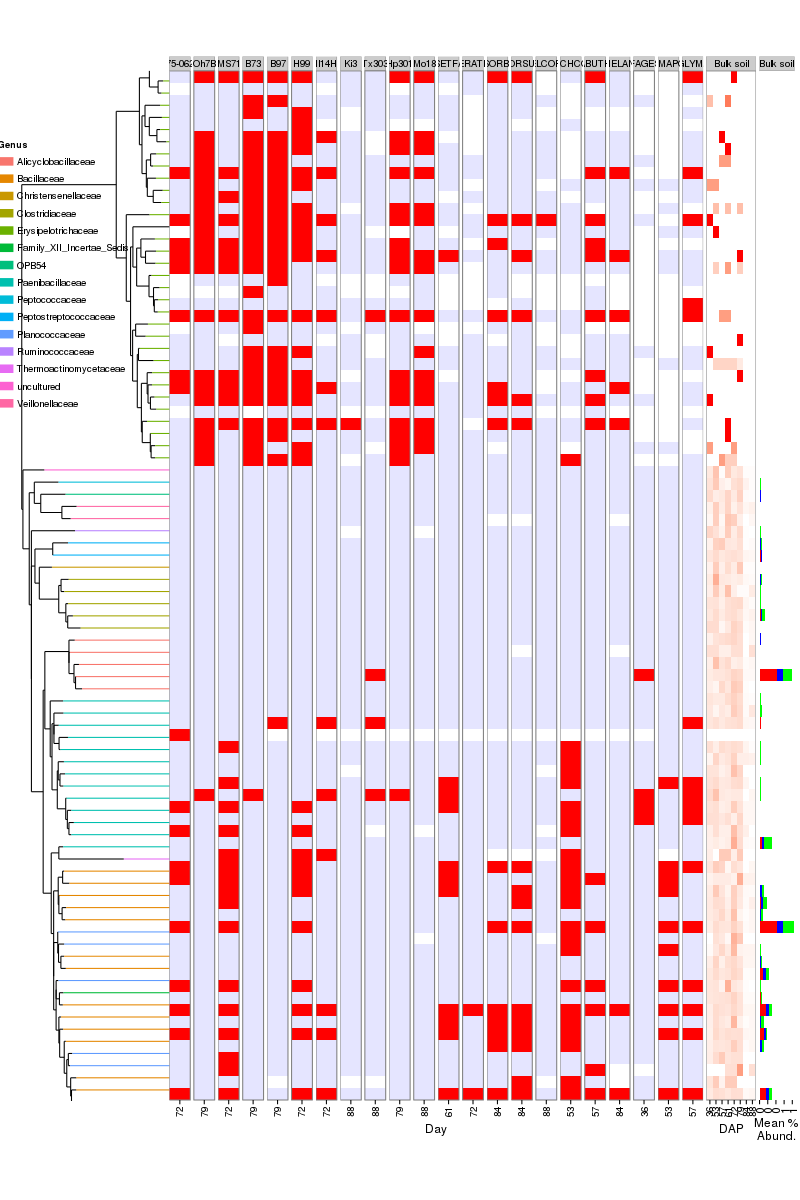

In [95]:
%%R -w 800 -h 1200

# phylum selection
phylum = "Firmicutes"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank5',
                   legend.title='Genus',
                   legend.position=c(0.3,.8),
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.6,1.8,0.18,0.15))
do.call(grid.arrange, gt)

In [104]:
%%R
TT = physeq.Full %>% tax_table %>% data.frame
colnames(TT)
TT[row.names(TT) == "OTU.1001",]

            Rank1      Rank2           Rank3              Rank4
OTU.1001 Bacteria Firmicutes Erysipelotrichi Erysipelotrichales
                       Rank5          Rank6                Rank7 Rank8
OTU.1001 Erysipelotrichaceae Asteroleplasma uncultured_bacterium  <NA>


In [243]:
%%R -i figDir

outFile = 'Firmicutes_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [305]:
%%R -i figDir

outFile = 'Firmicutes_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=500 / 65)
grid.arrange(p.tree, p.responders, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

png 
  2 


## Gemmatimonadetes

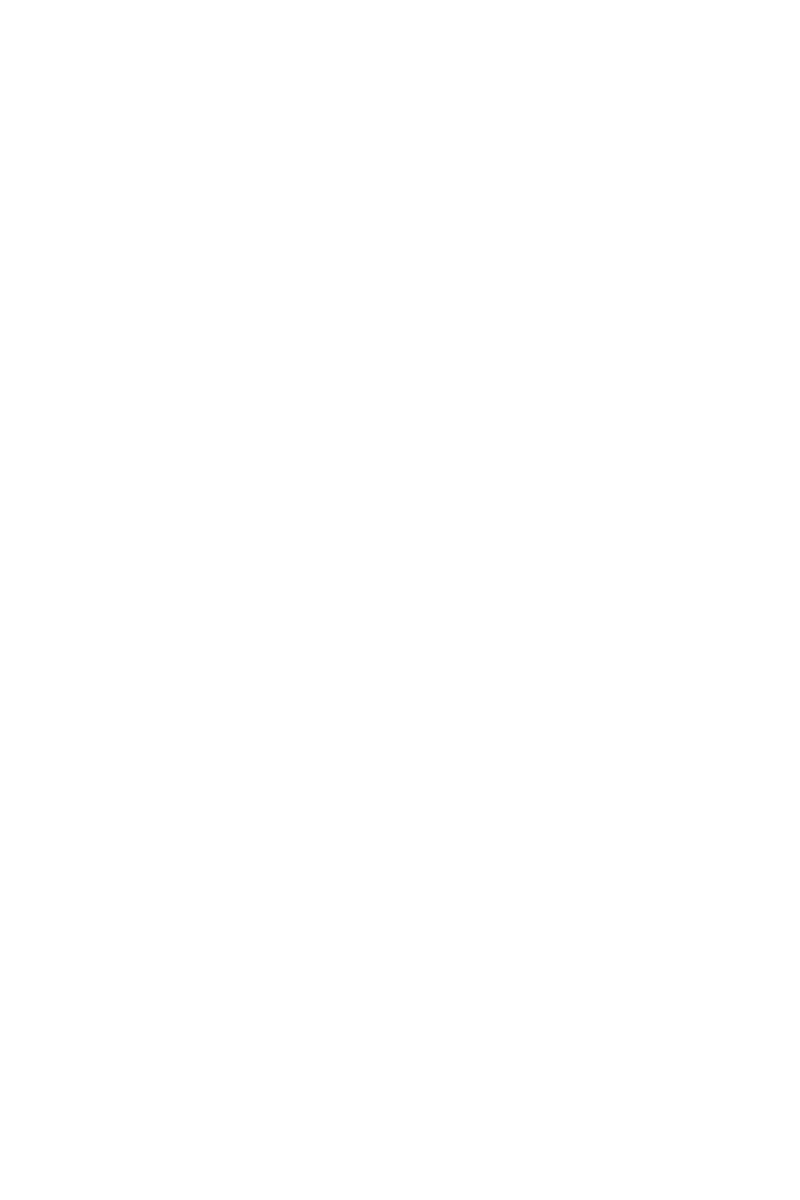

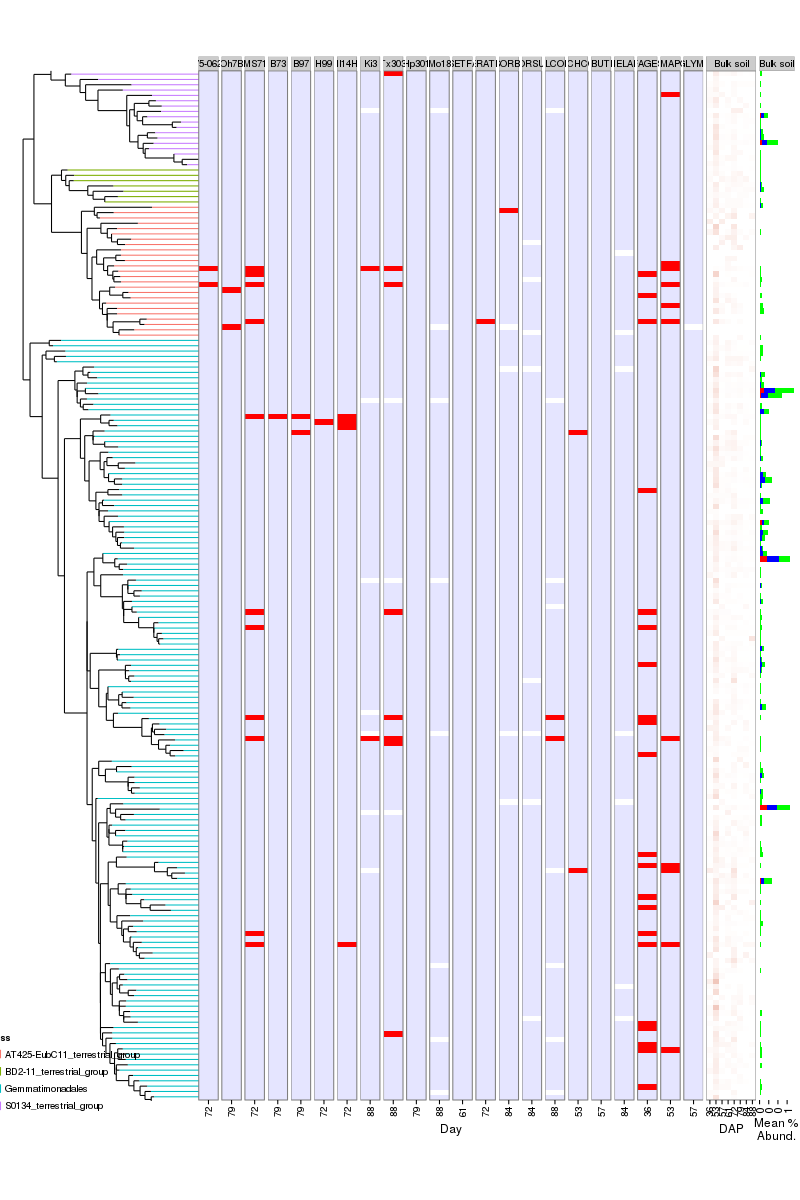

In [246]:
%%R -w 800 -h 1200

# phylum selection
phylum = "Gemmatimonadetes"
physeq_1phy = subset_taxa(physeq.Full, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.25,0.025),
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_type(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.bare, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.rel.abund, p.rel.total.abund),
                    widths=c(.7,1.7,0.18,0.15))
do.call(grid.arrange, gt)

In [247]:
%%R -i figDir

outFile = 'Gemma_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 
